In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
print(cuda, device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

%cd drive/MyDrive/ime_project/
!ls

True cuda:0
/content/drive/MyDrive/ime_project
capston_EDA.ipynb  done		   EDA_1030.ipynb  feature_selection2.ipynb  trial.ipynb
checkpoint.pt	   EDA_1003.ipynb  EDA_1101.ipynb  feature_selection.ipynb   var.ipynb
data		   EDA_1010.ipynb  EDA_1102.ipynb  lightning_logs
DL		   EDA_1019.ipynb  EDA_1201.ipynb  result


# preprocess

In [8]:
with open('result/final_selection.pkl', 'rb') as file:
    final_selection = pickle.load(file)

In [9]:
features = []
for i in final_selection.keys():
    # print(i)
    for j in final_selection[i]:
        if j not in features:
            features.append(j)
            # print(features)
        else: pass

# features.append('cdate')

In [10]:
target = ['plant2_temperature','plant3_temperature','plant4_temperature','plant5_temperature','plant6_temperature','plant7_temperature','plant8_temperature','plant9_temperature','plant10_temperature']

In [11]:
# 앞선 feature selection으로 선택한 feature들로만 이루어진 training dataset
df_train = pd.read_csv("result/dataset.csv")#, index_col="Unnamed: 0")
df_train.rename(columns={'Unnamed: 0':'cdate'},inplace=True)

df_train["cdate"] = pd.to_datetime(df_train["cdate"])
min_date = df_train["cdate"].min()
df_train['time_idx'] = df_train["cdate"].apply(lambda x: (x - min_date).total_seconds()/60/10) # 10분단위로 timestamp
df_train['time_idx'] = df_train['time_idx'].astype(int)

df_train.set_index("cdate", inplace=True)
df_train = df_train[features]

df_train.columns = df_train.columns.str.lower()
df_train['onoff'] = df_train.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

df_train.drop("plant1_temperature", axis=1, inplace=True)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_train.columns:
    missing_col_name = col + "_missing"
    df_train[missing_col_name] = df_train[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_train[col].fillna(df_train[col].mean(), inplace=True)
    df_train.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
print(len(df_train.columns))
df_train = df_train.loc[:"2023-07-31 23:00:00"]
df_train.tail(1)

False
27


ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-07-31 23:00:00       0.0       0.0       0.0       0.0       0.0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-07-31 23:00:00       0.0       0.0       0.0        0.0        0.0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-07-31 23:00:00               27.87               27.89   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-07-31 23:00:00               28.05            41.15               28.87   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-07-31 23:00:00                30.84        0.0            41.48   

                     plant9_temperature  onoff  
cdate                                           
2023-07-31 23:00:00               30.67      0  

[1 rows x 27 columns]

In [12]:
df_test = pd.read_csv("result/test.csv", index_col="cdate")
df_test.index = pd.to_datetime(df_test.index)

features.remove('Plant1_temperature')
features_low = [i.lower() for i in features]
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
print(len(df_test.columns))

df_test.head(1)

False
27


ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  ahu7_inv  \
cdate                                                                    
2023-08-01         0         0         0         0         0         0   

            ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  plant5_temperature  \
cdate                                                 ...                       
2023-08-01         0         0          0          0  ...               27.85   

            plant6_temperature  plant7_temperature  plant7_humidity  \
cdate                                                                 
2023-08-01               27.85               27.98            41.65   

            plant8_temperature  plant10_temperature  ahu13_inv  \
cdate                                                            
2023-08-01               28.85                30.68          0   

            plant4_humidity  plant9_temperature  onoff  
cdate                                                   
2023-08-01            41.87               30.61      0  

[1 rows x 27 columns]

In [13]:
y = df_train.loc[:,target]
X = df_train.drop(columns=target)

In [14]:
y.head(2)

plant2_temperature  plant3_temperature  \
cdate                                                         
2023-01-01 08:00:00               26.15               26.16   
2023-01-01 08:10:00               26.23               26.20   

                     plant4_temperature  plant5_temperature  \
cdate                                                         
2023-01-01 08:00:00               25.83               25.84   
2023-01-01 08:10:00               25.93               25.88   

                     plant6_temperature  plant7_temperature  \
cdate                                                         
2023-01-01 08:00:00               25.83                25.7   
2023-01-01 08:10:00               25.95                25.7   

                     plant8_temperature  plant9_temperature  \
cdate                                                         
2023-01-01 08:00:00               26.31               23.09   
2023-01-01 08:10:00               26.38               23.49   

                     plant10_temperature  
cdate                                     
2023-01-01 08:00:00                23.36  
2023-01-01 08:10:00                23.73

In [15]:
X.head(2)

ahu1_inv  ahu2_inv  ahu3_inv   ahu4_inv   ahu5_inv  \
cdate                                                                     
2023-01-01 08:00:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:10:00      35.0  18.90246      35.0  19.266979  18.445291   

                      ahu7_inv   ahu8_inv   ahu9_inv  ahu10_inv  ahu11_inv  \
cdate                                                                        
2023-01-01 08:00:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:10:00  18.043542  20.834108  19.026433  19.656569  19.619934   

                     ahu12_inv  ahu14_inv  plant2_humidity  plant3_humidity  \
cdate                                                                         
2023-01-01 08:00:00  20.200386  20.810474            38.95            38.78   
2023-01-01 08:10:00  20.200386  20.810474            39.01            39.07   

                     plant7_humidity  ahu13_inv  plant4_humidity  onoff  
cdate                                                                    
2023-01-01 08:00:00            40.07  19.713945            39.42      1  
2023-01-01 08:10:00            41.96  19.713945            39.62      1

# trainning

In [16]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

len_train = int(len(df_train)*0.8) # training 80% , validation 20%

X_train = X_ss[:len_train, :]
X_test = X_ss[len_train:, :]

y_train = y_ms[:len_train, :]
y_test = y_ms[len_train:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (24380, 18) (24380, 9)
Testing Shape (6095, 18) (6095, 9)


In [18]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

window_size = 6

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], window_size, -1))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], window_size, -1))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([24380, 6, 3]) torch.Size([24380, 9])
Testing Shape torch.Size([6095, 6, 3]) torch.Size([6095, 9])


In [19]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.dropout(out)
        out = self.relu(out)
        # out = out[:,-1,:]
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [20]:
num_epochs = 1000000
learning_rate = 1e-6

input_size = X_train_tensors_f.size(-1)

early_stopping = EarlyStopping(patience=10000, verbose=False) # 모델이 더 이상 성능이 향상되지 않을 때 학습을 조기에 중단하는 기법

hidden_size = 32
num_layers = 1
num_classes = y_train_tensors.shape[1]

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-8) # weight decay는 모델의 복잡성을 줄이고 과적합 방지하는 정규화 기법
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # schedular는 학습 과정 중 learning rate 조정하여 wegiht 조정하여 성능 개선하는 기

In [21]:
loss_list = []
for epoch in tqdm(range(num_epochs)):
    model.train() # 학습모드

    X_train_tensors_f = X_train_tensors_f.to(device)
    y_train_tensors = y_train_tensors.to(device)

    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)

    early_stopping(loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    # scheduler.step()

    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

model.load_state_dict(torch.load('checkpoint.pt'))


  0%|          | 4/1000000 [00:01<88:47:30,  3.13it/s] 

Epoch: 0, loss: 0.32334


  0%|          | 1017/1000000 [00:10<2:12:03, 126.08it/s]

Epoch: 1000, loss: 0.31237


  0%|          | 2018/1000000 [00:20<3:17:27, 84.24it/s]

Epoch: 2000, loss: 0.30154


  0%|          | 3021/1000000 [00:34<2:37:00, 105.84it/s]

Epoch: 3000, loss: 0.29073


  0%|          | 4025/1000000 [00:45<2:20:33, 118.09it/s]

Epoch: 4000, loss: 0.27986


  1%|          | 5026/1000000 [00:53<2:09:21, 128.19it/s]

Epoch: 5000, loss: 0.26893


  1%|          | 6019/1000000 [01:05<2:53:10, 95.66it/s]

Epoch: 6000, loss: 0.25788


  1%|          | 7027/1000000 [01:13<2:12:03, 125.32it/s]

Epoch: 7000, loss: 0.24663


  1%|          | 8018/1000000 [01:22<2:15:48, 121.74it/s]

Epoch: 8000, loss: 0.23528


  1%|          | 9020/1000000 [01:30<2:13:16, 123.93it/s]

Epoch: 9000, loss: 0.22388


  1%|          | 10016/1000000 [01:38<2:14:28, 122.69it/s]

Epoch: 10000, loss: 0.21208


  1%|          | 11023/1000000 [01:47<2:20:13, 117.55it/s]

Epoch: 11000, loss: 0.20017


  1%|          | 12021/1000000 [01:55<2:08:20, 128.29it/s]

Epoch: 12000, loss: 0.18821


  1%|▏         | 13021/1000000 [02:03<2:08:54, 127.61it/s]

Epoch: 13000, loss: 0.17600


  1%|▏         | 14020/1000000 [02:11<2:13:27, 123.14it/s]

Epoch: 14000, loss: 0.16368


  2%|▏         | 15020/1000000 [02:19<2:05:21, 130.95it/s]

Epoch: 15000, loss: 0.15126


  2%|▏         | 16018/1000000 [02:27<2:02:40, 133.68it/s]

Epoch: 16000, loss: 0.13882


  2%|▏         | 17021/1000000 [02:36<2:11:09, 124.91it/s]

Epoch: 17000, loss: 0.12680


  2%|▏         | 18017/1000000 [02:44<2:06:37, 129.24it/s]

Epoch: 18000, loss: 0.11471


  2%|▏         | 19019/1000000 [02:52<2:08:11, 127.55it/s]

Epoch: 19000, loss: 0.10343


  2%|▏         | 20015/1000000 [03:00<2:17:49, 118.51it/s]

Epoch: 20000, loss: 0.09218


  2%|▏         | 21027/1000000 [03:08<2:02:34, 133.12it/s]

Epoch: 21000, loss: 0.08175


  2%|▏         | 22017/1000000 [03:16<2:14:37, 121.07it/s]

Epoch: 22000, loss: 0.07181


  2%|▏         | 23022/1000000 [03:24<2:00:39, 134.96it/s]

Epoch: 23000, loss: 0.06312


  2%|▏         | 24016/1000000 [03:32<2:32:36, 106.58it/s]

Epoch: 24000, loss: 0.05531


  3%|▎         | 25017/1000000 [03:40<1:55:33, 140.62it/s]

Epoch: 25000, loss: 0.04851


  3%|▎         | 26028/1000000 [03:47<2:03:52, 131.04it/s]

Epoch: 26000, loss: 0.04311


  3%|▎         | 27023/1000000 [03:55<1:57:52, 137.58it/s]

Epoch: 27000, loss: 0.03861


  3%|▎         | 28017/1000000 [04:06<2:02:23, 132.37it/s]

Epoch: 28000, loss: 0.03496


  3%|▎         | 29027/1000000 [04:13<2:00:36, 134.17it/s]

Epoch: 29000, loss: 0.03218


  3%|▎         | 30026/1000000 [04:20<1:51:56, 144.43it/s]

Epoch: 30000, loss: 0.03012


  3%|▎         | 31017/1000000 [04:27<1:46:22, 151.83it/s]

Epoch: 31000, loss: 0.02878


  3%|▎         | 32017/1000000 [04:34<1:55:22, 139.82it/s]

Epoch: 32000, loss: 0.02753


  3%|▎         | 33023/1000000 [04:40<1:44:44, 153.86it/s]

Epoch: 33000, loss: 0.02663


  3%|▎         | 34020/1000000 [04:47<1:50:39, 145.49it/s]

Epoch: 34000, loss: 0.02593


  4%|▎         | 35024/1000000 [04:54<1:44:04, 154.52it/s]

Epoch: 35000, loss: 0.02517


  4%|▎         | 36014/1000000 [05:00<1:55:18, 139.34it/s]

Epoch: 36000, loss: 0.02463


  4%|▎         | 37021/1000000 [05:07<1:43:38, 154.85it/s]

Epoch: 37000, loss: 0.02409


  4%|▍         | 38019/1000000 [05:14<1:48:06, 148.30it/s]

Epoch: 38000, loss: 0.02359


  4%|▍         | 39023/1000000 [05:20<1:45:14, 152.20it/s]

Epoch: 39000, loss: 0.02309


  4%|▍         | 40020/1000000 [05:27<1:42:05, 156.71it/s]

Epoch: 40000, loss: 0.02274


  4%|▍         | 41020/1000000 [05:34<1:49:45, 145.63it/s]

Epoch: 41000, loss: 0.02233


  4%|▍         | 42031/1000000 [05:40<1:42:52, 155.21it/s]

Epoch: 42000, loss: 0.02190


  4%|▍         | 43025/1000000 [05:47<1:51:45, 142.71it/s]

Epoch: 43000, loss: 0.02168


  4%|▍         | 44029/1000000 [05:54<1:42:13, 155.85it/s]

Epoch: 44000, loss: 0.02125


  5%|▍         | 45025/1000000 [06:00<1:48:12, 147.09it/s]

Epoch: 45000, loss: 0.02104


  5%|▍         | 46032/1000000 [06:07<1:42:36, 154.95it/s]

Epoch: 46000, loss: 0.02086


  5%|▍         | 47026/1000000 [06:13<1:48:01, 147.02it/s]

Epoch: 47000, loss: 0.02064


  5%|▍         | 48029/1000000 [06:20<1:42:46, 154.37it/s]

Epoch: 48000, loss: 0.02049


  5%|▍         | 49027/1000000 [06:27<1:41:56, 155.48it/s]

Epoch: 49000, loss: 0.02027


  5%|▌         | 50029/1000000 [06:33<1:42:34, 154.35it/s]

Epoch: 50000, loss: 0.02016


  5%|▌         | 51021/1000000 [06:40<1:41:36, 155.67it/s]

Epoch: 51000, loss: 0.01994


  5%|▌         | 52022/1000000 [06:46<1:50:16, 143.28it/s]

Epoch: 52000, loss: 0.01981


  5%|▌         | 53022/1000000 [06:53<1:40:43, 156.68it/s]

Epoch: 53000, loss: 0.01969


  5%|▌         | 54023/1000000 [07:00<1:48:54, 144.77it/s]

Epoch: 54000, loss: 0.01953


  6%|▌         | 55022/1000000 [07:06<1:40:57, 156.00it/s]

Epoch: 55000, loss: 0.01934


  6%|▌         | 56018/1000000 [07:13<1:46:54, 147.17it/s]

Epoch: 56000, loss: 0.01930


  6%|▌         | 57029/1000000 [07:19<1:41:17, 155.15it/s]

Epoch: 57000, loss: 0.01918


  6%|▌         | 58022/1000000 [07:26<1:43:12, 152.12it/s]

Epoch: 58000, loss: 0.01908


  6%|▌         | 59024/1000000 [07:33<1:40:44, 155.66it/s]

Epoch: 59000, loss: 0.01899


  6%|▌         | 60017/1000000 [07:39<1:41:25, 154.45it/s]

Epoch: 60000, loss: 0.01873


  6%|▌         | 61028/1000000 [07:46<1:48:26, 144.32it/s]

Epoch: 61000, loss: 0.01877


  6%|▌         | 62031/1000000 [07:53<1:41:18, 154.32it/s]

Epoch: 62000, loss: 0.01873


  6%|▋         | 63017/1000000 [07:59<1:47:47, 144.88it/s]

Epoch: 63000, loss: 0.01860


  6%|▋         | 64030/1000000 [08:06<1:39:45, 156.37it/s]

Epoch: 64000, loss: 0.01855


  7%|▋         | 65020/1000000 [08:12<1:42:44, 151.68it/s]

Epoch: 65000, loss: 0.01842


  7%|▋         | 66029/1000000 [08:19<1:39:36, 156.28it/s]

Epoch: 66000, loss: 0.01828


  7%|▋         | 67024/1000000 [08:25<1:42:52, 151.14it/s]

Epoch: 67000, loss: 0.01818


  7%|▋         | 68023/1000000 [08:32<1:43:18, 150.35it/s]

Epoch: 68000, loss: 0.01816


  7%|▋         | 69031/1000000 [08:39<1:41:21, 153.07it/s]

Epoch: 69000, loss: 0.01812


  7%|▋         | 70021/1000000 [08:45<1:50:27, 140.32it/s]

Epoch: 70000, loss: 0.01811


  7%|▋         | 71022/1000000 [08:52<1:40:37, 153.88it/s]

Epoch: 71000, loss: 0.01790


  7%|▋         | 72021/1000000 [08:59<1:48:38, 142.35it/s]

Epoch: 72000, loss: 0.01790


  7%|▋         | 73024/1000000 [09:06<1:41:13, 152.64it/s]

Epoch: 73000, loss: 0.01785


  7%|▋         | 74023/1000000 [09:12<1:45:44, 145.95it/s]

Epoch: 74000, loss: 0.01777


  8%|▊         | 75027/1000000 [09:19<1:40:40, 153.13it/s]

Epoch: 75000, loss: 0.01773


  8%|▊         | 76019/1000000 [09:25<1:42:44, 149.90it/s]

Epoch: 76000, loss: 0.01771


  8%|▊         | 77030/1000000 [09:32<1:40:46, 152.64it/s]

Epoch: 77000, loss: 0.01761


  8%|▊         | 78022/1000000 [09:39<1:42:12, 150.35it/s]

Epoch: 78000, loss: 0.01755


  8%|▊         | 79016/1000000 [09:46<1:45:43, 145.19it/s]

Epoch: 79000, loss: 0.01746


  8%|▊         | 80023/1000000 [09:52<1:40:12, 153.01it/s]

Epoch: 80000, loss: 0.01739


  8%|▊         | 81016/1000000 [09:59<1:50:41, 138.36it/s]

Epoch: 81000, loss: 0.01738


  8%|▊         | 82029/1000000 [10:06<1:39:47, 153.31it/s]

Epoch: 82000, loss: 0.01740


  8%|▊         | 83018/1000000 [10:13<1:45:24, 145.00it/s]

Epoch: 83000, loss: 0.01721


  8%|▊         | 84019/1000000 [10:19<1:39:05, 154.06it/s]

Epoch: 84000, loss: 0.01729


  9%|▊         | 85023/1000000 [10:26<1:48:33, 140.48it/s]

Epoch: 85000, loss: 0.01719


  9%|▊         | 86028/1000000 [10:33<1:38:57, 153.92it/s]

Epoch: 86000, loss: 0.01720


  9%|▊         | 87020/1000000 [10:39<1:39:34, 152.81it/s]

Epoch: 87000, loss: 0.01713


  9%|▉         | 88026/1000000 [10:46<1:39:09, 153.28it/s]

Epoch: 88000, loss: 0.01706


  9%|▉         | 89018/1000000 [10:52<1:37:17, 156.07it/s]

Epoch: 89000, loss: 0.01712


  9%|▉         | 90020/1000000 [10:59<1:47:11, 141.48it/s]

Epoch: 90000, loss: 0.01702


  9%|▉         | 91022/1000000 [11:06<1:40:04, 151.38it/s]

Epoch: 91000, loss: 0.01699


  9%|▉         | 92024/1000000 [11:12<1:46:53, 141.57it/s]

Epoch: 92000, loss: 0.01693


  9%|▉         | 93019/1000000 [11:19<1:38:29, 153.48it/s]

Epoch: 93000, loss: 0.01694


  9%|▉         | 94016/1000000 [11:26<1:46:09, 142.24it/s]

Epoch: 94000, loss: 0.01687


 10%|▉         | 95019/1000000 [11:32<1:36:52, 155.69it/s]

Epoch: 95000, loss: 0.01683


 10%|▉         | 96027/1000000 [11:39<1:40:25, 150.02it/s]

Epoch: 96000, loss: 0.01682


 10%|▉         | 97018/1000000 [11:46<1:37:24, 154.51it/s]

Epoch: 97000, loss: 0.01675


 10%|▉         | 98026/1000000 [11:52<1:37:37, 153.98it/s]

Epoch: 98000, loss: 0.01676


 10%|▉         | 99028/1000000 [11:59<1:39:28, 150.94it/s]

Epoch: 99000, loss: 0.01678


 10%|█         | 100024/1000000 [12:06<1:38:01, 153.02it/s]

Epoch: 100000, loss: 0.01680


 10%|█         | 101020/1000000 [12:12<1:45:27, 142.07it/s]

Epoch: 101000, loss: 0.01663


 10%|█         | 102019/1000000 [12:19<1:38:35, 151.79it/s]

Epoch: 102000, loss: 0.01660


 10%|█         | 103027/1000000 [12:26<1:45:00, 142.36it/s]

Epoch: 103000, loss: 0.01663


 10%|█         | 104016/1000000 [12:32<1:36:09, 155.30it/s]

Epoch: 104000, loss: 0.01657


 11%|█         | 105026/1000000 [12:39<1:46:15, 140.38it/s]

Epoch: 105000, loss: 0.01647


 11%|█         | 106027/1000000 [12:46<1:36:01, 155.15it/s]

Epoch: 106000, loss: 0.01640


 11%|█         | 107022/1000000 [12:52<1:34:49, 156.95it/s]

Epoch: 107000, loss: 0.01643


 11%|█         | 108023/1000000 [12:59<1:35:47, 155.19it/s]

Epoch: 108000, loss: 0.01634


 11%|█         | 109031/1000000 [13:05<1:35:23, 155.66it/s]

Epoch: 109000, loss: 0.01637


 11%|█         | 110030/1000000 [13:12<1:41:04, 146.76it/s]

Epoch: 110000, loss: 0.01635


 11%|█         | 111019/1000000 [13:18<1:35:02, 155.89it/s]

Epoch: 111000, loss: 0.01621


 11%|█         | 112031/1000000 [13:25<1:38:56, 149.57it/s]

Epoch: 112000, loss: 0.01623


 11%|█▏        | 113024/1000000 [13:32<1:37:16, 151.96it/s]

Epoch: 113000, loss: 0.01620


 11%|█▏        | 114024/1000000 [13:38<1:41:33, 145.40it/s]

Epoch: 114000, loss: 0.01624


 12%|█▏        | 115030/1000000 [13:45<1:35:22, 154.65it/s]

Epoch: 115000, loss: 0.01617


 12%|█▏        | 116022/1000000 [13:51<1:36:12, 153.12it/s]

Epoch: 116000, loss: 0.01610


 12%|█▏        | 117029/1000000 [13:58<1:35:57, 153.37it/s]

Epoch: 117000, loss: 0.01611


 12%|█▏        | 118023/1000000 [14:05<1:35:31, 153.89it/s]

Epoch: 118000, loss: 0.01598


 12%|█▏        | 119020/1000000 [14:12<1:46:16, 138.16it/s]

Epoch: 119000, loss: 0.01596


 12%|█▏        | 120018/1000000 [14:19<1:43:49, 141.26it/s]

Epoch: 120000, loss: 0.01596


 12%|█▏        | 121020/1000000 [14:25<1:41:31, 144.29it/s]

Epoch: 121000, loss: 0.01593


 12%|█▏        | 122019/1000000 [14:32<1:36:36, 151.47it/s]

Epoch: 122000, loss: 0.01585


 12%|█▏        | 123028/1000000 [14:39<1:40:46, 145.05it/s]

Epoch: 123000, loss: 0.01584


 12%|█▏        | 124027/1000000 [14:45<1:35:35, 152.74it/s]

Epoch: 124000, loss: 0.01578


 13%|█▎        | 125017/1000000 [14:52<1:41:12, 144.09it/s]

Epoch: 125000, loss: 0.01578


 13%|█▎        | 126032/1000000 [14:59<1:35:17, 152.85it/s]

Epoch: 126000, loss: 0.01568


 13%|█▎        | 127024/1000000 [15:05<1:36:15, 151.16it/s]

Epoch: 127000, loss: 0.01560


 13%|█▎        | 128022/1000000 [15:12<1:33:41, 155.11it/s]

Epoch: 128000, loss: 0.01562


 13%|█▎        | 129028/1000000 [15:19<1:35:15, 152.40it/s]

Epoch: 129000, loss: 0.01561


 13%|█▎        | 130016/1000000 [15:25<1:42:18, 141.73it/s]

Epoch: 130000, loss: 0.01554


 13%|█▎        | 131019/1000000 [15:32<1:35:11, 152.15it/s]

Epoch: 131000, loss: 0.01549


 13%|█▎        | 132026/1000000 [15:39<1:43:27, 139.83it/s]

Epoch: 132000, loss: 0.01540


 13%|█▎        | 133020/1000000 [15:45<1:33:43, 154.17it/s]

Epoch: 133000, loss: 0.01540


 13%|█▎        | 134017/1000000 [15:52<1:41:20, 142.42it/s]

Epoch: 134000, loss: 0.01529


 14%|█▎        | 135028/1000000 [15:59<1:32:19, 156.15it/s]

Epoch: 135000, loss: 0.01543


 14%|█▎        | 136021/1000000 [16:05<1:32:55, 154.95it/s]

Epoch: 136000, loss: 0.01532


 14%|█▎        | 137031/1000000 [16:12<1:33:26, 153.93it/s]

Epoch: 137000, loss: 0.01521


 14%|█▍        | 138024/1000000 [16:18<1:31:42, 156.64it/s]

Epoch: 138000, loss: 0.01515


 14%|█▍        | 139023/1000000 [16:25<1:35:38, 150.03it/s]

Epoch: 139000, loss: 0.01518


 14%|█▍        | 140031/1000000 [16:32<1:32:07, 155.58it/s]

Epoch: 140000, loss: 0.01514


 14%|█▍        | 141017/1000000 [16:38<1:36:12, 148.79it/s]

Epoch: 141000, loss: 0.01505


 14%|█▍        | 142020/1000000 [16:45<1:35:13, 150.18it/s]

Epoch: 142000, loss: 0.01499


 14%|█▍        | 143029/1000000 [16:51<1:38:15, 145.35it/s]

Epoch: 143000, loss: 0.01495


 14%|█▍        | 144017/1000000 [16:58<1:31:55, 155.20it/s]

Epoch: 144000, loss: 0.01499


 15%|█▍        | 145027/1000000 [17:04<1:40:27, 141.85it/s]

Epoch: 145000, loss: 0.01493


 15%|█▍        | 146020/1000000 [17:11<1:32:41, 153.56it/s]

Epoch: 146000, loss: 0.01490


 15%|█▍        | 147032/1000000 [17:18<1:29:59, 157.97it/s]

Epoch: 147000, loss: 0.01482


 15%|█▍        | 148028/1000000 [17:24<1:31:21, 155.41it/s]

Epoch: 148000, loss: 0.01481


 15%|█▍        | 149028/1000000 [17:31<1:29:59, 157.61it/s]

Epoch: 149000, loss: 0.01477


 15%|█▌        | 150030/1000000 [17:37<1:37:40, 145.03it/s]

Epoch: 150000, loss: 0.01469


 15%|█▌        | 151019/1000000 [17:44<1:29:42, 157.72it/s]

Epoch: 151000, loss: 0.01469


 15%|█▌        | 152027/1000000 [17:50<1:37:19, 145.21it/s]

Epoch: 152000, loss: 0.01463


 15%|█▌        | 153024/1000000 [17:57<1:29:50, 157.13it/s]

Epoch: 153000, loss: 0.01459


 15%|█▌        | 154023/1000000 [18:03<1:36:46, 145.69it/s]

Epoch: 154000, loss: 0.01459


 16%|█▌        | 155030/1000000 [18:10<1:29:43, 156.96it/s]

Epoch: 155000, loss: 0.01454


 16%|█▌        | 156031/1000000 [18:16<1:29:24, 157.33it/s]

Epoch: 156000, loss: 0.01454


 16%|█▌        | 157017/1000000 [18:23<1:30:08, 155.87it/s]

Epoch: 157000, loss: 0.01440


 16%|█▌        | 158021/1000000 [18:29<1:29:56, 156.03it/s]

Epoch: 158000, loss: 0.01436


 16%|█▌        | 159026/1000000 [18:36<1:41:20, 138.31it/s]

Epoch: 159000, loss: 0.01432


 16%|█▌        | 160029/1000000 [18:43<1:31:25, 153.14it/s]

Epoch: 160000, loss: 0.01433


 16%|█▌        | 161018/1000000 [18:49<1:39:33, 140.45it/s]

Epoch: 161000, loss: 0.01427


 16%|█▌        | 162023/1000000 [18:56<1:29:32, 155.96it/s]

Epoch: 162000, loss: 0.01425


 16%|█▋        | 163017/1000000 [19:02<1:33:57, 148.47it/s]

Epoch: 163000, loss: 0.01416


 16%|█▋        | 164019/1000000 [19:09<1:29:33, 155.56it/s]

Epoch: 164000, loss: 0.01411


 17%|█▋        | 165028/1000000 [19:15<1:29:28, 155.54it/s]

Epoch: 165000, loss: 0.01407


 17%|█▋        | 166031/1000000 [19:22<1:29:39, 155.02it/s]

Epoch: 166000, loss: 0.01404


 17%|█▋        | 167030/1000000 [19:29<1:28:45, 156.41it/s]

Epoch: 167000, loss: 0.01402


 17%|█▋        | 168017/1000000 [19:35<1:35:18, 145.49it/s]

Epoch: 168000, loss: 0.01403


 17%|█▋        | 169020/1000000 [19:42<1:28:57, 155.70it/s]

Epoch: 169000, loss: 0.01392


 17%|█▋        | 170028/1000000 [19:48<1:37:45, 141.49it/s]

Epoch: 170000, loss: 0.01387


 17%|█▋        | 171017/1000000 [19:55<1:28:13, 156.59it/s]

Epoch: 171000, loss: 0.01385


 17%|█▋        | 172017/1000000 [20:01<1:33:13, 148.02it/s]

Epoch: 172000, loss: 0.01382


 17%|█▋        | 173027/1000000 [20:08<1:29:09, 154.58it/s]

Epoch: 173000, loss: 0.01381


 17%|█▋        | 174025/1000000 [20:14<1:29:32, 153.74it/s]

Epoch: 174000, loss: 0.01372


 18%|█▊        | 175030/1000000 [20:21<1:30:15, 152.35it/s]

Epoch: 175000, loss: 0.01380


 18%|█▊        | 176032/1000000 [20:28<1:28:38, 154.91it/s]

Epoch: 176000, loss: 0.01375


 18%|█▊        | 177026/1000000 [20:34<1:32:38, 148.05it/s]

Epoch: 177000, loss: 0.01366


 18%|█▊        | 178029/1000000 [20:41<1:29:48, 152.55it/s]

Epoch: 178000, loss: 0.01346


 18%|█▊        | 179025/1000000 [20:47<1:34:05, 145.43it/s]

Epoch: 179000, loss: 0.01350


 18%|█▊        | 180025/1000000 [20:54<1:28:35, 154.25it/s]

Epoch: 180000, loss: 0.01352


 18%|█▊        | 181024/1000000 [21:00<1:31:04, 149.86it/s]

Epoch: 181000, loss: 0.01347


 18%|█▊        | 182029/1000000 [21:07<1:26:12, 158.13it/s]

Epoch: 182000, loss: 0.01344


 18%|█▊        | 183030/1000000 [21:13<1:28:50, 153.27it/s]

Epoch: 183000, loss: 0.01340


 18%|█▊        | 184024/1000000 [21:20<1:28:09, 154.27it/s]

Epoch: 184000, loss: 0.01335


 19%|█▊        | 185019/1000000 [21:27<1:27:42, 154.86it/s]

Epoch: 185000, loss: 0.01336


 19%|█▊        | 186017/1000000 [21:33<1:33:57, 144.39it/s]

Epoch: 186000, loss: 0.01332


 19%|█▊        | 187022/1000000 [21:40<1:27:45, 154.39it/s]

Epoch: 187000, loss: 0.01329


 19%|█▉        | 188023/1000000 [21:46<1:30:12, 150.01it/s]

Epoch: 188000, loss: 0.01327


 19%|█▉        | 189017/1000000 [21:53<1:28:29, 152.73it/s]

Epoch: 189000, loss: 0.01325


 19%|█▉        | 190021/1000000 [21:59<1:38:43, 136.74it/s]

Epoch: 190000, loss: 0.01316


 19%|█▉        | 191020/1000000 [22:06<1:26:36, 155.69it/s]

Epoch: 191000, loss: 0.01317


 19%|█▉        | 192028/1000000 [22:12<1:35:01, 141.70it/s]

Epoch: 192000, loss: 0.01304


 19%|█▉        | 193022/1000000 [22:19<1:26:11, 156.04it/s]

Epoch: 193000, loss: 0.01313


 19%|█▉        | 194017/1000000 [22:25<1:28:59, 150.94it/s]

Epoch: 194000, loss: 0.01301


 20%|█▉        | 195023/1000000 [22:32<1:25:27, 156.99it/s]

Epoch: 195000, loss: 0.01305


 20%|█▉        | 196018/1000000 [22:38<1:26:03, 155.71it/s]

Epoch: 196000, loss: 0.01299


 20%|█▉        | 197023/1000000 [22:45<1:24:48, 157.80it/s]

Epoch: 197000, loss: 0.01299


 20%|█▉        | 198027/1000000 [22:51<1:23:28, 160.13it/s]

Epoch: 198000, loss: 0.01292


 20%|█▉        | 199027/1000000 [22:58<1:23:46, 159.36it/s]

Epoch: 199000, loss: 0.01287


 20%|██        | 200018/1000000 [23:04<1:24:17, 158.18it/s]

Epoch: 200000, loss: 0.01289


 20%|██        | 201029/1000000 [23:11<1:25:12, 156.29it/s]

Epoch: 201000, loss: 0.01286


 20%|██        | 202023/1000000 [23:17<1:23:43, 158.84it/s]

Epoch: 202000, loss: 0.01285


 20%|██        | 203029/1000000 [23:23<1:26:42, 153.19it/s]

Epoch: 203000, loss: 0.01283


 20%|██        | 204032/1000000 [23:30<1:25:22, 155.39it/s]

Epoch: 204000, loss: 0.01278


 21%|██        | 205027/1000000 [23:36<1:30:53, 145.76it/s]

Epoch: 205000, loss: 0.01272


 21%|██        | 206032/1000000 [23:43<1:24:16, 157.02it/s]

Epoch: 206000, loss: 0.01266


 21%|██        | 207016/1000000 [23:49<1:31:53, 143.83it/s]

Epoch: 207000, loss: 0.01271


 21%|██        | 208017/1000000 [23:56<1:24:25, 156.36it/s]

Epoch: 208000, loss: 0.01258


 21%|██        | 209022/1000000 [24:02<1:27:04, 151.41it/s]

Epoch: 209000, loss: 0.01263


 21%|██        | 210023/1000000 [24:09<1:22:52, 158.88it/s]

Epoch: 210000, loss: 0.01260


 21%|██        | 211026/1000000 [24:15<1:33:05, 141.25it/s]

Epoch: 211000, loss: 0.01255


 21%|██        | 212024/1000000 [24:22<1:23:40, 156.94it/s]

Epoch: 212000, loss: 0.01256


 21%|██▏       | 213017/1000000 [24:28<1:32:43, 141.45it/s]

Epoch: 213000, loss: 0.01252


 21%|██▏       | 214025/1000000 [24:35<1:24:53, 154.32it/s]

Epoch: 214000, loss: 0.01252


 22%|██▏       | 215018/1000000 [24:42<1:25:35, 152.84it/s]

Epoch: 215000, loss: 0.01251


 22%|██▏       | 216025/1000000 [24:49<1:25:10, 153.42it/s]

Epoch: 216000, loss: 0.01247


 22%|██▏       | 217017/1000000 [24:55<1:26:37, 150.63it/s]

Epoch: 217000, loss: 0.01238


 22%|██▏       | 218032/1000000 [25:02<1:24:13, 154.75it/s]

Epoch: 218000, loss: 0.01238


 22%|██▏       | 219023/1000000 [25:09<1:32:29, 140.74it/s]

Epoch: 219000, loss: 0.01234


 22%|██▏       | 220031/1000000 [25:16<1:25:23, 152.25it/s]

Epoch: 220000, loss: 0.01242


 22%|██▏       | 221023/1000000 [25:22<1:25:22, 152.06it/s]

Epoch: 221000, loss: 0.01234


 22%|██▏       | 222016/1000000 [25:29<1:27:37, 147.97it/s]

Epoch: 222000, loss: 0.01230


 22%|██▏       | 223024/1000000 [25:36<1:23:34, 154.94it/s]

Epoch: 223000, loss: 0.01234


 22%|██▏       | 224015/1000000 [25:43<1:32:39, 139.57it/s]

Epoch: 224000, loss: 0.01228


 23%|██▎       | 225022/1000000 [25:49<1:24:06, 153.56it/s]

Epoch: 225000, loss: 0.01223


 23%|██▎       | 226019/1000000 [25:56<1:30:24, 142.67it/s]

Epoch: 226000, loss: 0.01227


 23%|██▎       | 227022/1000000 [26:02<1:24:58, 151.61it/s]

Epoch: 227000, loss: 0.01224


 23%|██▎       | 228018/1000000 [26:09<1:32:50, 138.59it/s]

Epoch: 228000, loss: 0.01220


 23%|██▎       | 229031/1000000 [26:16<1:23:10, 154.47it/s]

Epoch: 229000, loss: 0.01215


 23%|██▎       | 230023/1000000 [26:22<1:33:27, 137.32it/s]

Epoch: 230000, loss: 0.01216


 23%|██▎       | 231027/1000000 [26:29<1:23:25, 153.63it/s]

Epoch: 231000, loss: 0.01209


 23%|██▎       | 232026/1000000 [26:36<1:28:19, 144.91it/s]

Epoch: 232000, loss: 0.01215


 23%|██▎       | 233032/1000000 [26:42<1:23:43, 152.68it/s]

Epoch: 233000, loss: 0.01209


 23%|██▎       | 234019/1000000 [26:49<1:30:05, 141.70it/s]

Epoch: 234000, loss: 0.01207


 24%|██▎       | 235032/1000000 [26:55<1:23:06, 153.42it/s]

Epoch: 235000, loss: 0.01212


 24%|██▎       | 236027/1000000 [27:02<1:21:35, 156.06it/s]

Epoch: 236000, loss: 0.01202


 24%|██▎       | 237028/1000000 [27:09<1:20:54, 157.15it/s]

Epoch: 237000, loss: 0.01200


 24%|██▍       | 238020/1000000 [27:15<1:22:03, 154.77it/s]

Epoch: 238000, loss: 0.01201


 24%|██▍       | 239018/1000000 [27:22<1:21:51, 154.92it/s]

Epoch: 239000, loss: 0.01201


 24%|██▍       | 240027/1000000 [27:28<1:21:06, 156.15it/s]

Epoch: 240000, loss: 0.01193


 24%|██▍       | 241025/1000000 [27:35<1:20:57, 156.26it/s]

Epoch: 241000, loss: 0.01194


 24%|██▍       | 242021/1000000 [27:41<1:21:57, 154.15it/s]

Epoch: 242000, loss: 0.01192


 24%|██▍       | 243027/1000000 [27:48<1:24:16, 149.69it/s]

Epoch: 243000, loss: 0.01190


 24%|██▍       | 244025/1000000 [27:54<1:20:43, 156.08it/s]

Epoch: 244000, loss: 0.01193


 25%|██▍       | 245025/1000000 [28:01<1:25:40, 146.87it/s]

Epoch: 245000, loss: 0.01190


 25%|██▍       | 246020/1000000 [28:07<1:21:15, 154.65it/s]

Epoch: 246000, loss: 0.01192


 25%|██▍       | 247019/1000000 [28:14<1:25:15, 147.19it/s]

Epoch: 247000, loss: 0.01187


 25%|██▍       | 248025/1000000 [28:20<1:20:38, 155.43it/s]

Epoch: 248000, loss: 0.01183


 25%|██▍       | 249016/1000000 [28:27<1:23:42, 149.51it/s]

Epoch: 249000, loss: 0.01180


 25%|██▌       | 250031/1000000 [28:33<1:18:57, 158.32it/s]

Epoch: 250000, loss: 0.01184


 25%|██▌       | 251019/1000000 [28:39<1:22:42, 150.94it/s]

Epoch: 251000, loss: 0.01177


 25%|██▌       | 252018/1000000 [28:46<1:17:59, 159.83it/s]

Epoch: 252000, loss: 0.01176


 25%|██▌       | 253028/1000000 [28:52<1:18:26, 158.71it/s]

Epoch: 253000, loss: 0.01172


 25%|██▌       | 254029/1000000 [28:59<1:19:59, 155.44it/s]

Epoch: 254000, loss: 0.01175


 26%|██▌       | 255026/1000000 [29:05<1:19:26, 156.29it/s]

Epoch: 255000, loss: 0.01168


 26%|██▌       | 256026/1000000 [29:12<1:18:51, 157.23it/s]

Epoch: 256000, loss: 0.01165


 26%|██▌       | 257030/1000000 [29:19<1:19:34, 155.61it/s]

Epoch: 257000, loss: 0.01171


 26%|██▌       | 258030/1000000 [29:25<1:19:19, 155.90it/s]

Epoch: 258000, loss: 0.01172


 26%|██▌       | 259026/1000000 [29:31<1:18:08, 158.05it/s]

Epoch: 259000, loss: 0.01166


 26%|██▌       | 260028/1000000 [29:38<1:25:25, 144.38it/s]

Epoch: 260000, loss: 0.01164


 26%|██▌       | 261017/1000000 [29:44<1:18:26, 157.02it/s]

Epoch: 261000, loss: 0.01165


 26%|██▌       | 262030/1000000 [29:51<1:23:20, 147.57it/s]

Epoch: 262000, loss: 0.01157


 26%|██▋       | 263031/1000000 [29:58<1:18:23, 156.67it/s]

Epoch: 263000, loss: 0.01154


 26%|██▋       | 264016/1000000 [30:04<1:28:07, 139.18it/s]

Epoch: 264000, loss: 0.01152


 27%|██▋       | 265018/1000000 [30:11<1:18:04, 156.90it/s]

Epoch: 265000, loss: 0.01152


 27%|██▋       | 266023/1000000 [30:17<1:22:50, 147.68it/s]

Epoch: 266000, loss: 0.01148


 27%|██▋       | 267029/1000000 [30:24<1:20:08, 152.44it/s]

Epoch: 267000, loss: 0.01152


 27%|██▋       | 268025/1000000 [30:30<1:24:52, 143.72it/s]

Epoch: 268000, loss: 0.01149


 27%|██▋       | 269032/1000000 [30:37<1:18:24, 155.38it/s]

Epoch: 269000, loss: 0.01144


 27%|██▋       | 270025/1000000 [30:43<1:18:50, 154.30it/s]

Epoch: 270000, loss: 0.01147


 27%|██▋       | 271024/1000000 [30:50<1:20:12, 151.49it/s]

Epoch: 271000, loss: 0.01149


 27%|██▋       | 272022/1000000 [30:57<1:17:42, 156.13it/s]

Epoch: 272000, loss: 0.01139


 27%|██▋       | 273017/1000000 [31:03<1:17:45, 155.83it/s]

Epoch: 273000, loss: 0.01135


 27%|██▋       | 274028/1000000 [31:10<1:19:01, 153.10it/s]

Epoch: 274000, loss: 0.01142


 28%|██▊       | 275031/1000000 [31:16<1:20:35, 149.92it/s]

Epoch: 275000, loss: 0.01135


 28%|██▊       | 276022/1000000 [31:23<1:20:53, 149.18it/s]

Epoch: 276000, loss: 0.01136


 28%|██▊       | 277018/1000000 [31:30<1:20:26, 149.78it/s]

Epoch: 277000, loss: 0.01133


 28%|██▊       | 278026/1000000 [31:36<1:18:42, 152.89it/s]

Epoch: 278000, loss: 0.01138


 28%|██▊       | 279027/1000000 [31:43<1:25:41, 140.22it/s]

Epoch: 279000, loss: 0.01130


 28%|██▊       | 280018/1000000 [31:49<1:16:55, 156.00it/s]

Epoch: 280000, loss: 0.01131


 28%|██▊       | 281021/1000000 [31:56<1:18:40, 152.32it/s]

Epoch: 281000, loss: 0.01129


 28%|██▊       | 282024/1000000 [32:03<1:17:37, 154.15it/s]

Epoch: 282000, loss: 0.01129


 28%|██▊       | 283018/1000000 [32:09<1:23:22, 143.33it/s]

Epoch: 283000, loss: 0.01123


 28%|██▊       | 284030/1000000 [32:16<1:17:27, 154.05it/s]

Epoch: 284000, loss: 0.01122


 29%|██▊       | 285029/1000000 [32:22<1:23:47, 142.22it/s]

Epoch: 285000, loss: 0.01125


 29%|██▊       | 286024/1000000 [32:29<1:17:55, 152.71it/s]

Epoch: 286000, loss: 0.01122


 29%|██▊       | 287026/1000000 [32:36<1:22:26, 144.12it/s]

Epoch: 287000, loss: 0.01117


 29%|██▉       | 288030/1000000 [32:42<1:16:21, 155.42it/s]

Epoch: 288000, loss: 0.01119


 29%|██▉       | 289023/1000000 [32:49<1:21:42, 145.03it/s]

Epoch: 289000, loss: 0.01116


 29%|██▉       | 290020/1000000 [32:55<1:15:41, 156.32it/s]

Epoch: 290000, loss: 0.01115


 29%|██▉       | 291031/1000000 [33:02<1:16:00, 155.47it/s]

Epoch: 291000, loss: 0.01117


 29%|██▉       | 292028/1000000 [33:09<1:15:43, 155.82it/s]

Epoch: 292000, loss: 0.01117


 29%|██▉       | 293025/1000000 [33:15<1:14:13, 158.75it/s]

Epoch: 293000, loss: 0.01110


 29%|██▉       | 294024/1000000 [33:22<1:15:00, 156.86it/s]

Epoch: 294000, loss: 0.01104


 30%|██▉       | 295026/1000000 [33:28<1:14:53, 156.89it/s]

Epoch: 295000, loss: 0.01108


 30%|██▉       | 296023/1000000 [33:35<1:15:12, 156.02it/s]

Epoch: 296000, loss: 0.01101


 30%|██▉       | 297031/1000000 [33:41<1:16:47, 152.56it/s]

Epoch: 297000, loss: 0.01100


 30%|██▉       | 298020/1000000 [33:48<1:21:16, 143.95it/s]

Epoch: 298000, loss: 0.01109


 30%|██▉       | 299029/1000000 [33:54<1:15:53, 153.93it/s]

Epoch: 299000, loss: 0.01104


 30%|███       | 300016/1000000 [34:01<1:19:56, 145.93it/s]

Epoch: 300000, loss: 0.01101


 30%|███       | 301017/1000000 [34:07<1:15:41, 153.90it/s]

Epoch: 301000, loss: 0.01098


 30%|███       | 302024/1000000 [34:14<1:21:38, 142.47it/s]

Epoch: 302000, loss: 0.01098


 30%|███       | 303019/1000000 [34:20<1:17:09, 150.56it/s]

Epoch: 303000, loss: 0.01093


 30%|███       | 304020/1000000 [34:27<1:17:01, 150.60it/s]

Epoch: 304000, loss: 0.01095


 31%|███       | 305025/1000000 [34:34<1:14:05, 156.34it/s]

Epoch: 305000, loss: 0.01096


 31%|███       | 306028/1000000 [34:40<1:19:14, 145.95it/s]

Epoch: 306000, loss: 0.01092


 31%|███       | 307030/1000000 [34:47<1:13:16, 157.60it/s]

Epoch: 307000, loss: 0.01095


 31%|███       | 308022/1000000 [34:53<1:17:37, 148.57it/s]

Epoch: 308000, loss: 0.01089


 31%|███       | 309028/1000000 [35:00<1:14:26, 154.70it/s]

Epoch: 309000, loss: 0.01088


 31%|███       | 310021/1000000 [35:07<1:14:29, 154.36it/s]

Epoch: 310000, loss: 0.01090


 31%|███       | 311032/1000000 [35:13<1:14:19, 154.50it/s]

Epoch: 311000, loss: 0.01084


 31%|███       | 312026/1000000 [35:20<1:15:22, 152.14it/s]

Epoch: 312000, loss: 0.01085


 31%|███▏      | 313025/1000000 [35:27<1:13:43, 155.29it/s]

Epoch: 313000, loss: 0.01085


 31%|███▏      | 314017/1000000 [35:33<1:14:50, 152.77it/s]

Epoch: 314000, loss: 0.01086


 32%|███▏      | 315031/1000000 [35:40<1:15:12, 151.78it/s]

Epoch: 315000, loss: 0.01083


 32%|███▏      | 316023/1000000 [35:47<1:15:23, 151.21it/s]

Epoch: 316000, loss: 0.01082


 32%|███▏      | 317016/1000000 [35:53<1:21:44, 139.26it/s]

Epoch: 317000, loss: 0.01079


 32%|███▏      | 318018/1000000 [36:00<1:14:05, 153.41it/s]

Epoch: 318000, loss: 0.01078


 32%|███▏      | 319029/1000000 [36:07<1:14:54, 151.51it/s]

Epoch: 319000, loss: 0.01082


 32%|███▏      | 320023/1000000 [36:14<1:12:29, 156.35it/s]

Epoch: 320000, loss: 0.01079


 32%|███▏      | 321019/1000000 [36:20<1:22:24, 137.32it/s]

Epoch: 321000, loss: 0.01075


 32%|███▏      | 322025/1000000 [36:27<1:12:54, 154.98it/s]

Epoch: 322000, loss: 0.01073


 32%|███▏      | 323031/1000000 [36:33<1:16:24, 147.67it/s]

Epoch: 323000, loss: 0.01072


 32%|███▏      | 324018/1000000 [36:40<1:13:50, 152.58it/s]

Epoch: 324000, loss: 0.01070


 33%|███▎      | 325020/1000000 [36:46<1:16:08, 147.76it/s]

Epoch: 325000, loss: 0.01069


 33%|███▎      | 326030/1000000 [36:53<1:14:47, 150.19it/s]

Epoch: 326000, loss: 0.01070


 33%|███▎      | 327029/1000000 [37:00<1:16:18, 146.99it/s]

Epoch: 327000, loss: 0.01063


 33%|███▎      | 328021/1000000 [37:06<1:14:09, 151.01it/s]

Epoch: 328000, loss: 0.01073


 33%|███▎      | 329029/1000000 [37:13<1:17:27, 144.39it/s]

Epoch: 329000, loss: 0.01065


 33%|███▎      | 330023/1000000 [37:19<1:11:35, 155.97it/s]

Epoch: 330000, loss: 0.01067


 33%|███▎      | 331018/1000000 [37:26<1:11:52, 155.14it/s]

Epoch: 331000, loss: 0.01063


 33%|███▎      | 332029/1000000 [37:33<1:12:38, 153.25it/s]

Epoch: 332000, loss: 0.01064


 33%|███▎      | 333019/1000000 [37:39<1:10:59, 156.57it/s]

Epoch: 333000, loss: 0.01061


 33%|███▎      | 334027/1000000 [37:46<1:11:18, 155.67it/s]

Epoch: 334000, loss: 0.01057


 34%|███▎      | 335024/1000000 [37:52<1:09:38, 159.16it/s]

Epoch: 335000, loss: 0.01060


 34%|███▎      | 336020/1000000 [37:59<1:13:02, 151.52it/s]

Epoch: 336000, loss: 0.01062


 34%|███▎      | 337028/1000000 [38:05<1:11:24, 154.75it/s]

Epoch: 337000, loss: 0.01053


 34%|███▍      | 338023/1000000 [38:12<1:15:32, 146.04it/s]

Epoch: 338000, loss: 0.01056


 34%|███▍      | 339032/1000000 [38:18<1:11:38, 153.77it/s]

Epoch: 339000, loss: 0.01054


 34%|███▍      | 340016/1000000 [38:25<1:16:30, 143.77it/s]

Epoch: 340000, loss: 0.01054


 34%|███▍      | 341018/1000000 [38:31<1:12:44, 151.00it/s]

Epoch: 341000, loss: 0.01048


 34%|███▍      | 342023/1000000 [38:38<1:16:21, 143.60it/s]

Epoch: 342000, loss: 0.01051


 34%|███▍      | 343027/1000000 [38:45<1:11:32, 153.04it/s]

Epoch: 343000, loss: 0.01053


 34%|███▍      | 344023/1000000 [38:51<1:15:07, 145.52it/s]

Epoch: 344000, loss: 0.01047


 35%|███▍      | 345022/1000000 [38:58<1:10:29, 154.87it/s]

Epoch: 345000, loss: 0.01049


 35%|███▍      | 346020/1000000 [39:05<1:15:20, 144.66it/s]

Epoch: 346000, loss: 0.01049


 35%|███▍      | 347017/1000000 [39:11<1:10:55, 153.43it/s]

Epoch: 347000, loss: 0.01043


 35%|███▍      | 348020/1000000 [39:18<1:17:51, 139.57it/s]

Epoch: 348000, loss: 0.01044


 35%|███▍      | 349019/1000000 [39:25<1:12:16, 150.13it/s]

Epoch: 349000, loss: 0.01043


 35%|███▌      | 350026/1000000 [39:31<1:14:17, 145.82it/s]

Epoch: 350000, loss: 0.01041


 35%|███▌      | 351026/1000000 [39:38<1:11:16, 151.75it/s]

Epoch: 351000, loss: 0.01044


 35%|███▌      | 352031/1000000 [39:45<1:10:04, 154.11it/s]

Epoch: 352000, loss: 0.01039


 35%|███▌      | 353023/1000000 [39:52<1:10:31, 152.89it/s]

Epoch: 353000, loss: 0.01041


 35%|███▌      | 354017/1000000 [39:58<1:08:27, 157.27it/s]

Epoch: 354000, loss: 0.01033


 36%|███▌      | 355026/1000000 [40:05<1:09:52, 153.85it/s]

Epoch: 355000, loss: 0.01040


 36%|███▌      | 356022/1000000 [40:11<1:08:41, 156.26it/s]

Epoch: 356000, loss: 0.01036


 36%|███▌      | 357025/1000000 [40:18<1:09:03, 155.17it/s]

Epoch: 357000, loss: 0.01035


 36%|███▌      | 358018/1000000 [40:25<1:09:53, 153.10it/s]

Epoch: 358000, loss: 0.01032


 36%|███▌      | 359025/1000000 [40:31<1:10:14, 152.10it/s]

Epoch: 359000, loss: 0.01035


 36%|███▌      | 360018/1000000 [40:38<1:10:57, 150.32it/s]

Epoch: 360000, loss: 0.01036


 36%|███▌      | 361020/1000000 [40:45<1:15:35, 140.88it/s]

Epoch: 361000, loss: 0.01030


 36%|███▌      | 362027/1000000 [40:51<1:10:03, 151.77it/s]

Epoch: 362000, loss: 0.01034


 36%|███▋      | 363018/1000000 [40:58<1:15:11, 141.20it/s]

Epoch: 363000, loss: 0.01032


 36%|███▋      | 364030/1000000 [41:04<1:09:04, 153.44it/s]

Epoch: 364000, loss: 0.01031


 37%|███▋      | 365021/1000000 [41:11<1:14:58, 141.17it/s]

Epoch: 365000, loss: 0.01027


 37%|███▋      | 366026/1000000 [41:18<1:09:12, 152.66it/s]

Epoch: 366000, loss: 0.01028


 37%|███▋      | 367025/1000000 [41:24<1:10:12, 150.25it/s]

Epoch: 367000, loss: 0.01026


 37%|███▋      | 368021/1000000 [41:31<1:07:39, 155.69it/s]

Epoch: 368000, loss: 0.01020


 37%|███▋      | 369024/1000000 [41:37<1:15:53, 138.56it/s]

Epoch: 369000, loss: 0.01023


 37%|███▋      | 370027/1000000 [41:44<1:08:24, 153.50it/s]

Epoch: 370000, loss: 0.01023


 37%|███▋      | 371020/1000000 [41:51<1:08:32, 152.95it/s]

Epoch: 371000, loss: 0.01018


 37%|███▋      | 372029/1000000 [41:57<1:07:29, 155.09it/s]

Epoch: 372000, loss: 0.01018


 37%|███▋      | 373022/1000000 [42:04<1:08:42, 152.09it/s]

Epoch: 373000, loss: 0.01018


 37%|███▋      | 374025/1000000 [42:11<1:07:52, 153.70it/s]

Epoch: 374000, loss: 0.01021


 38%|███▊      | 375017/1000000 [42:17<1:07:34, 154.14it/s]

Epoch: 375000, loss: 0.01018


 38%|███▊      | 376027/1000000 [42:24<1:07:41, 153.65it/s]

Epoch: 376000, loss: 0.01016


 38%|███▊      | 377019/1000000 [42:30<1:07:40, 153.41it/s]

Epoch: 377000, loss: 0.01013


 38%|███▊      | 378024/1000000 [42:37<1:08:19, 151.70it/s]

Epoch: 378000, loss: 0.01017


 38%|███▊      | 379017/1000000 [42:44<1:06:16, 156.16it/s]

Epoch: 379000, loss: 0.01014


 38%|███▊      | 380030/1000000 [42:50<1:11:25, 144.66it/s]

Epoch: 380000, loss: 0.01009


 38%|███▊      | 381027/1000000 [42:57<1:06:03, 156.17it/s]

Epoch: 381000, loss: 0.01011


 38%|███▊      | 382021/1000000 [43:03<1:11:50, 143.38it/s]

Epoch: 382000, loss: 0.01014


 38%|███▊      | 383023/1000000 [43:10<1:06:40, 154.22it/s]

Epoch: 383000, loss: 0.01009


 38%|███▊      | 384026/1000000 [43:16<1:09:22, 147.97it/s]

Epoch: 384000, loss: 0.01011


 39%|███▊      | 385025/1000000 [43:23<1:05:42, 155.99it/s]

Epoch: 385000, loss: 0.01008


 39%|███▊      | 386031/1000000 [43:29<1:09:34, 147.08it/s]

Epoch: 386000, loss: 0.01006


 39%|███▊      | 387019/1000000 [43:36<1:04:42, 157.87it/s]

Epoch: 387000, loss: 0.01002


 39%|███▉      | 388022/1000000 [43:42<1:09:33, 146.65it/s]

Epoch: 388000, loss: 0.01001


 39%|███▉      | 389018/1000000 [43:49<1:04:58, 156.72it/s]

Epoch: 389000, loss: 0.01004


 39%|███▉      | 390030/1000000 [43:55<1:07:31, 150.56it/s]

Epoch: 390000, loss: 0.01000


 39%|███▉      | 391032/1000000 [44:02<1:04:44, 156.78it/s]

Epoch: 391000, loss: 0.01003


 39%|███▉      | 392030/1000000 [44:08<1:04:15, 157.71it/s]

Epoch: 392000, loss: 0.00999


 39%|███▉      | 393032/1000000 [44:15<1:04:02, 157.96it/s]

Epoch: 393000, loss: 0.00998


 39%|███▉      | 394027/1000000 [44:22<1:04:46, 155.91it/s]

Epoch: 394000, loss: 0.00997


 40%|███▉      | 395024/1000000 [44:28<1:06:02, 152.66it/s]

Epoch: 395000, loss: 0.00999


 40%|███▉      | 396017/1000000 [44:35<1:06:01, 152.46it/s]

Epoch: 396000, loss: 0.00995


 40%|███▉      | 397017/1000000 [44:42<1:11:07, 141.29it/s]

Epoch: 397000, loss: 0.00990


 40%|███▉      | 398024/1000000 [44:48<1:04:52, 154.66it/s]

Epoch: 398000, loss: 0.00998


 40%|███▉      | 399026/1000000 [44:55<1:10:21, 142.35it/s]

Epoch: 399000, loss: 0.00994


 40%|████      | 400028/1000000 [45:01<1:05:34, 152.51it/s]

Epoch: 400000, loss: 0.00996


 40%|████      | 401028/1000000 [45:08<1:11:36, 139.41it/s]

Epoch: 401000, loss: 0.00991


 40%|████      | 402032/1000000 [45:15<1:04:51, 153.68it/s]

Epoch: 402000, loss: 0.00994


 40%|████      | 403025/1000000 [45:22<1:11:22, 139.41it/s]

Epoch: 403000, loss: 0.00992


 40%|████      | 404031/1000000 [45:28<1:04:28, 154.06it/s]

Epoch: 404000, loss: 0.00992


 41%|████      | 405016/1000000 [45:35<1:08:17, 145.20it/s]

Epoch: 405000, loss: 0.00989


 41%|████      | 406032/1000000 [45:42<1:05:09, 151.94it/s]

Epoch: 406000, loss: 0.00987


 41%|████      | 407025/1000000 [45:48<1:07:59, 145.35it/s]

Epoch: 407000, loss: 0.00985


 41%|████      | 408020/1000000 [45:55<1:04:18, 153.44it/s]

Epoch: 408000, loss: 0.00990


 41%|████      | 409028/1000000 [46:01<1:05:08, 151.19it/s]

Epoch: 409000, loss: 0.00985


 41%|████      | 410024/1000000 [46:08<1:03:35, 154.61it/s]

Epoch: 410000, loss: 0.00984


 41%|████      | 411016/1000000 [46:14<1:03:27, 154.68it/s]

Epoch: 411000, loss: 0.00987


 41%|████      | 412024/1000000 [46:21<1:03:43, 153.79it/s]

Epoch: 412000, loss: 0.00982


 41%|████▏     | 413032/1000000 [46:28<1:03:59, 152.88it/s]

Epoch: 413000, loss: 0.00981


 41%|████▏     | 414021/1000000 [46:35<1:21:13, 120.23it/s]

Epoch: 414000, loss: 0.00980


 42%|████▏     | 415018/1000000 [46:42<1:02:33, 155.85it/s]

Epoch: 415000, loss: 0.00980


 42%|████▏     | 416027/1000000 [46:48<1:05:38, 148.28it/s]

Epoch: 416000, loss: 0.00980


 42%|████▏     | 417029/1000000 [46:55<1:03:05, 154.00it/s]

Epoch: 417000, loss: 0.00976


 42%|████▏     | 418023/1000000 [47:01<1:05:47, 147.43it/s]

Epoch: 418000, loss: 0.00974


 42%|████▏     | 419019/1000000 [47:08<1:01:55, 156.39it/s]

Epoch: 419000, loss: 0.00975


 42%|████▏     | 420027/1000000 [47:15<1:02:40, 154.21it/s]

Epoch: 420000, loss: 0.00973


 42%|████▏     | 421032/1000000 [47:21<1:03:05, 152.93it/s]

Epoch: 421000, loss: 0.00975


 42%|████▏     | 422024/1000000 [47:28<1:01:42, 156.09it/s]

Epoch: 422000, loss: 0.00975


 42%|████▏     | 423032/1000000 [47:35<1:01:55, 155.27it/s]

Epoch: 423000, loss: 0.00971


 42%|████▏     | 424025/1000000 [47:41<1:02:12, 154.32it/s]

Epoch: 424000, loss: 0.00972


 43%|████▎     | 425025/1000000 [47:48<1:02:55, 152.27it/s]

Epoch: 425000, loss: 0.00973


 43%|████▎     | 426021/1000000 [47:54<1:00:50, 157.24it/s]

Epoch: 426000, loss: 0.00971


 43%|████▎     | 427024/1000000 [48:01<1:04:18, 148.50it/s]

Epoch: 427000, loss: 0.00968


 43%|████▎     | 428031/1000000 [48:07<1:00:54, 156.53it/s]

Epoch: 428000, loss: 0.00972


 43%|████▎     | 429029/1000000 [48:14<1:03:12, 150.54it/s]

Epoch: 429000, loss: 0.00966


 43%|████▎     | 430028/1000000 [48:20<1:00:48, 156.24it/s]

Epoch: 430000, loss: 0.00969


 43%|████▎     | 431016/1000000 [48:27<1:02:24, 151.94it/s]

Epoch: 431000, loss: 0.00963


 43%|████▎     | 432025/1000000 [48:33<1:01:21, 154.28it/s]

Epoch: 432000, loss: 0.00965


 43%|████▎     | 433026/1000000 [48:40<1:06:11, 142.75it/s]

Epoch: 433000, loss: 0.00967


 43%|████▎     | 434022/1000000 [48:46<1:02:25, 151.12it/s]

Epoch: 434000, loss: 0.00966


 44%|████▎     | 435030/1000000 [48:53<1:04:01, 147.09it/s]

Epoch: 435000, loss: 0.00963


 44%|████▎     | 436022/1000000 [49:00<1:03:04, 149.04it/s]

Epoch: 436000, loss: 0.00963


 44%|████▎     | 437027/1000000 [49:06<1:01:57, 151.45it/s]

Epoch: 437000, loss: 0.00962


 44%|████▍     | 438027/1000000 [49:13<1:01:10, 153.11it/s]

Epoch: 438000, loss: 0.00959


 44%|████▍     | 439019/1000000 [49:20<59:58, 155.89it/s]

Epoch: 439000, loss: 0.00957


 44%|████▍     | 440021/1000000 [49:27<1:02:24, 149.55it/s]

Epoch: 440000, loss: 0.00961


 44%|████▍     | 441028/1000000 [49:33<1:01:51, 150.60it/s]

Epoch: 441000, loss: 0.00959


 44%|████▍     | 442018/1000000 [49:40<1:00:49, 152.89it/s]

Epoch: 442000, loss: 0.00957


 44%|████▍     | 443026/1000000 [49:46<59:40, 155.56it/s]

Epoch: 443000, loss: 0.00950


 44%|████▍     | 444020/1000000 [49:53<1:02:26, 148.42it/s]

Epoch: 444000, loss: 0.00955


 45%|████▍     | 445028/1000000 [50:00<1:00:09, 153.77it/s]

Epoch: 445000, loss: 0.00955


 45%|████▍     | 446026/1000000 [50:06<1:04:35, 142.95it/s]

Epoch: 446000, loss: 0.00954


 45%|████▍     | 447030/1000000 [50:13<59:44, 154.25it/s]

Epoch: 447000, loss: 0.00952


 45%|████▍     | 448016/1000000 [50:20<1:03:39, 144.51it/s]

Epoch: 448000, loss: 0.00951


 45%|████▍     | 449028/1000000 [50:26<1:00:23, 152.07it/s]

Epoch: 449000, loss: 0.00952


 45%|████▌     | 450016/1000000 [50:33<1:04:03, 143.08it/s]

Epoch: 450000, loss: 0.00946


 45%|████▌     | 451029/1000000 [50:40<1:00:42, 150.72it/s]

Epoch: 451000, loss: 0.00950


 45%|████▌     | 452025/1000000 [50:46<1:05:04, 140.35it/s]

Epoch: 452000, loss: 0.00950


 45%|████▌     | 453022/1000000 [50:53<1:00:11, 151.46it/s]

Epoch: 453000, loss: 0.00949


 45%|████▌     | 454022/1000000 [50:59<1:05:53, 138.09it/s]

Epoch: 454000, loss: 0.00949


 46%|████▌     | 455027/1000000 [51:06<58:37, 154.94it/s]

Epoch: 455000, loss: 0.00949


 46%|████▌     | 456020/1000000 [51:13<1:00:58, 148.68it/s]

Epoch: 456000, loss: 0.00949


 46%|████▌     | 457030/1000000 [51:19<59:11, 152.90it/s]

Epoch: 457000, loss: 0.00949


 46%|████▌     | 458024/1000000 [51:26<58:25, 154.62it/s]

Epoch: 458000, loss: 0.00945


 46%|████▌     | 459021/1000000 [51:33<59:45, 150.86it/s]

Epoch: 459000, loss: 0.00946


 46%|████▌     | 460029/1000000 [51:39<59:50, 150.38it/s]

Epoch: 460000, loss: 0.00943


 46%|████▌     | 461018/1000000 [51:46<59:39, 150.57it/s]

Epoch: 461000, loss: 0.00944


 46%|████▌     | 462026/1000000 [51:53<58:46, 152.57it/s]

Epoch: 462000, loss: 0.00940


 46%|████▋     | 463026/1000000 [52:00<58:58, 151.76it/s]

Epoch: 463000, loss: 0.00937


 46%|████▋     | 464017/1000000 [52:06<58:58, 151.45it/s]

Epoch: 464000, loss: 0.00940


 47%|████▋     | 465029/1000000 [52:13<59:45, 149.21it/s]

Epoch: 465000, loss: 0.00937


 47%|████▋     | 466019/1000000 [52:20<58:29, 152.16it/s]

Epoch: 466000, loss: 0.00941


 47%|████▋     | 467022/1000000 [52:27<59:16, 149.88it/s]  

Epoch: 467000, loss: 0.00939


 47%|████▋     | 468029/1000000 [52:33<58:18, 152.07it/s]

Epoch: 468000, loss: 0.00937


 47%|████▋     | 469027/1000000 [52:40<1:02:15, 142.14it/s]

Epoch: 469000, loss: 0.00939


 47%|████▋     | 470029/1000000 [52:47<57:17, 154.19it/s]

Epoch: 470000, loss: 0.00938


 47%|████▋     | 471020/1000000 [52:53<1:01:55, 142.39it/s]

Epoch: 471000, loss: 0.00935


 47%|████▋     | 472018/1000000 [53:00<56:25, 155.96it/s]

Epoch: 472000, loss: 0.00933


 47%|████▋     | 473028/1000000 [53:06<59:23, 147.90it/s]

Epoch: 473000, loss: 0.00934


 47%|████▋     | 474018/1000000 [53:13<56:29, 155.18it/s]

Epoch: 474000, loss: 0.00934


 48%|████▊     | 475021/1000000 [53:19<57:27, 152.27it/s]

Epoch: 475000, loss: 0.00933


 48%|████▊     | 476031/1000000 [53:26<55:12, 158.18it/s]

Epoch: 476000, loss: 0.00932


 48%|████▊     | 477030/1000000 [53:32<55:11, 157.94it/s]

Epoch: 477000, loss: 0.00930


 48%|████▊     | 478027/1000000 [53:39<54:25, 159.85it/s]

Epoch: 478000, loss: 0.00928


 48%|████▊     | 479024/1000000 [53:45<56:11, 154.51it/s]

Epoch: 479000, loss: 0.00933


 48%|████▊     | 480018/1000000 [53:52<55:02, 157.46it/s]

Epoch: 480000, loss: 0.00930


 48%|████▊     | 481028/1000000 [53:58<56:35, 152.83it/s]

Epoch: 481000, loss: 0.00931


 48%|████▊     | 482028/1000000 [54:05<55:11, 156.39it/s]

Epoch: 482000, loss: 0.00929


 48%|████▊     | 483027/1000000 [54:11<56:56, 151.34it/s]

Epoch: 483000, loss: 0.00927


 48%|████▊     | 484031/1000000 [54:18<58:06, 147.97it/s]

Epoch: 484000, loss: 0.00930


 49%|████▊     | 485017/1000000 [54:24<55:09, 155.63it/s]

Epoch: 485000, loss: 0.00927


 49%|████▊     | 486030/1000000 [54:31<57:51, 148.07it/s]

Epoch: 486000, loss: 0.00921


 49%|████▊     | 487031/1000000 [54:38<54:49, 155.95it/s]

Epoch: 487000, loss: 0.00920


 49%|████▉     | 488017/1000000 [54:44<56:54, 149.96it/s]

Epoch: 488000, loss: 0.00924


 49%|████▉     | 489017/1000000 [54:51<55:37, 153.12it/s]

Epoch: 489000, loss: 0.00925


 49%|████▉     | 490019/1000000 [54:57<59:49, 142.08it/s]

Epoch: 490000, loss: 0.00922


 49%|████▉     | 491020/1000000 [55:04<55:17, 153.40it/s]

Epoch: 491000, loss: 0.00919


 49%|████▉     | 492029/1000000 [55:10<56:34, 149.66it/s]

Epoch: 492000, loss: 0.00918


 49%|████▉     | 493026/1000000 [55:17<54:26, 155.18it/s]

Epoch: 493000, loss: 0.00922


 49%|████▉     | 494021/1000000 [55:23<53:36, 157.30it/s]

Epoch: 494000, loss: 0.00920


 50%|████▉     | 495026/1000000 [55:30<53:58, 155.93it/s]

Epoch: 495000, loss: 0.00918


 50%|████▉     | 496022/1000000 [55:36<53:46, 156.18it/s]

Epoch: 496000, loss: 0.00917


 50%|████▉     | 497020/1000000 [55:43<55:01, 152.34it/s]

Epoch: 497000, loss: 0.00922


 50%|████▉     | 498029/1000000 [55:50<53:59, 154.98it/s]

Epoch: 498000, loss: 0.00917


 50%|████▉     | 499031/1000000 [55:56<55:53, 149.39it/s]

Epoch: 499000, loss: 0.00920


 50%|█████     | 500030/1000000 [56:03<53:34, 155.54it/s]

Epoch: 500000, loss: 0.00917


 50%|█████     | 501024/1000000 [56:09<59:42, 139.27it/s]

Epoch: 501000, loss: 0.00916


 50%|█████     | 502027/1000000 [56:16<54:20, 152.75it/s]

Epoch: 502000, loss: 0.00917


 50%|█████     | 503025/1000000 [56:23<58:50, 140.76it/s]  

Epoch: 503000, loss: 0.00916


 50%|█████     | 504023/1000000 [56:29<53:08, 155.57it/s]

Epoch: 504000, loss: 0.00915


 51%|█████     | 505023/1000000 [56:36<55:54, 147.54it/s]

Epoch: 505000, loss: 0.00913


 51%|█████     | 506030/1000000 [56:42<53:00, 155.30it/s]

Epoch: 506000, loss: 0.00915


 51%|█████     | 507020/1000000 [56:49<56:47, 144.67it/s]

Epoch: 507000, loss: 0.00908


 51%|█████     | 508025/1000000 [56:55<52:37, 155.83it/s]

Epoch: 508000, loss: 0.00909


 51%|█████     | 509020/1000000 [57:02<56:40, 144.39it/s]

Epoch: 509000, loss: 0.00912


 51%|█████     | 510020/1000000 [57:09<53:03, 153.94it/s]

Epoch: 510000, loss: 0.00912


 51%|█████     | 511029/1000000 [57:15<53:06, 153.43it/s]

Epoch: 511000, loss: 0.00912


 51%|█████     | 512028/1000000 [57:22<53:51, 151.00it/s]

Epoch: 512000, loss: 0.00907


 51%|█████▏    | 513020/1000000 [57:29<53:37, 151.35it/s]

Epoch: 513000, loss: 0.00911


 51%|█████▏    | 514017/1000000 [57:35<51:25, 157.51it/s]

Epoch: 514000, loss: 0.00910


 52%|█████▏    | 515026/1000000 [57:42<53:28, 151.17it/s]

Epoch: 515000, loss: 0.00905


 52%|█████▏    | 516019/1000000 [57:49<52:10, 154.62it/s]

Epoch: 516000, loss: 0.00905


 52%|█████▏    | 517028/1000000 [57:55<51:56, 154.95it/s]

Epoch: 517000, loss: 0.00907


 52%|█████▏    | 518027/1000000 [58:02<55:40, 144.28it/s]

Epoch: 518000, loss: 0.00905


 52%|█████▏    | 519017/1000000 [58:08<52:11, 153.59it/s]

Epoch: 519000, loss: 0.00911


 52%|█████▏    | 520025/1000000 [58:15<56:34, 141.38it/s]

Epoch: 520000, loss: 0.00906


 52%|█████▏    | 521018/1000000 [58:21<52:18, 152.61it/s]

Epoch: 521000, loss: 0.00902


 52%|█████▏    | 522018/1000000 [58:28<52:44, 151.04it/s]

Epoch: 522000, loss: 0.00902


 52%|█████▏    | 523025/1000000 [58:35<51:10, 155.36it/s]

Epoch: 523000, loss: 0.00902


 52%|█████▏    | 524029/1000000 [58:41<54:47, 144.78it/s]

Epoch: 524000, loss: 0.00904


 53%|█████▎    | 525027/1000000 [58:48<51:45, 152.95it/s]

Epoch: 525000, loss: 0.00904


 53%|█████▎    | 526019/1000000 [58:54<52:40, 149.96it/s]

Epoch: 526000, loss: 0.00898


 53%|█████▎    | 527027/1000000 [59:01<52:07, 151.23it/s]

Epoch: 527000, loss: 0.00901


 53%|█████▎    | 528018/1000000 [59:08<51:13, 153.58it/s]

Epoch: 528000, loss: 0.00899


 53%|█████▎    | 529027/1000000 [59:15<51:01, 153.86it/s]

Epoch: 529000, loss: 0.00898


 53%|█████▎    | 530018/1000000 [59:21<51:35, 151.81it/s]

Epoch: 530000, loss: 0.00899


 53%|█████▎    | 531020/1000000 [59:28<50:20, 155.26it/s]

Epoch: 531000, loss: 0.00901


 53%|█████▎    | 532028/1000000 [59:35<51:08, 152.52it/s]

Epoch: 532000, loss: 0.00895


 53%|█████▎    | 533024/1000000 [59:41<49:39, 156.71it/s]

Epoch: 533000, loss: 0.00899


 53%|█████▎    | 534018/1000000 [59:48<50:58, 152.34it/s]

Epoch: 534000, loss: 0.00897


 54%|█████▎    | 535016/1000000 [59:55<56:32, 137.07it/s]

Epoch: 535000, loss: 0.00896


 54%|█████▎    | 536020/1000000 [1:00:01<50:38, 152.72it/s]

Epoch: 536000, loss: 0.00897


 54%|█████▎    | 537018/1000000 [1:00:08<53:00, 145.58it/s]

Epoch: 537000, loss: 0.00895


 54%|█████▍    | 538032/1000000 [1:00:15<50:32, 152.35it/s]

Epoch: 538000, loss: 0.00897


 54%|█████▍    | 539017/1000000 [1:00:21<53:18, 144.12it/s]

Epoch: 539000, loss: 0.00898


 54%|█████▍    | 540020/1000000 [1:00:28<50:02, 153.22it/s]

Epoch: 540000, loss: 0.00894


 54%|█████▍    | 541023/1000000 [1:00:34<51:57, 147.24it/s]

Epoch: 541000, loss: 0.00890


 54%|█████▍    | 542027/1000000 [1:00:41<50:21, 151.57it/s]

Epoch: 542000, loss: 0.00892


 54%|█████▍    | 543019/1000000 [1:00:48<50:36, 150.50it/s]

Epoch: 543000, loss: 0.00891


 54%|█████▍    | 544026/1000000 [1:00:54<49:45, 152.75it/s]

Epoch: 544000, loss: 0.00891


 55%|█████▍    | 545021/1000000 [1:01:01<48:37, 155.95it/s]

Epoch: 545000, loss: 0.00892


 55%|█████▍    | 546030/1000000 [1:01:08<48:46, 155.13it/s]

Epoch: 546000, loss: 0.00892


 55%|█████▍    | 547022/1000000 [1:01:14<49:14, 153.31it/s]

Epoch: 547000, loss: 0.00891


 55%|█████▍    | 548021/1000000 [1:01:21<48:59, 153.74it/s]

Epoch: 548000, loss: 0.00889


 55%|█████▍    | 549016/1000000 [1:01:27<49:28, 151.95it/s]

Epoch: 549000, loss: 0.00891


 55%|█████▌    | 550021/1000000 [1:01:34<49:42, 150.88it/s]

Epoch: 550000, loss: 0.00891


 55%|█████▌    | 551029/1000000 [1:01:41<48:40, 153.71it/s]

Epoch: 551000, loss: 0.00888


 55%|█████▌    | 552022/1000000 [1:01:47<54:06, 137.99it/s]

Epoch: 552000, loss: 0.00891


 55%|█████▌    | 553030/1000000 [1:01:54<48:20, 154.09it/s]

Epoch: 553000, loss: 0.00886


 55%|█████▌    | 554020/1000000 [1:02:01<50:57, 145.84it/s]

Epoch: 554000, loss: 0.00888


 56%|█████▌    | 555020/1000000 [1:02:07<47:20, 156.67it/s]

Epoch: 555000, loss: 0.00886


 56%|█████▌    | 556031/1000000 [1:02:14<49:11, 150.44it/s]

Epoch: 556000, loss: 0.00885


 56%|█████▌    | 557026/1000000 [1:02:20<48:05, 153.50it/s]

Epoch: 557000, loss: 0.00886


 56%|█████▌    | 558029/1000000 [1:02:27<50:24, 146.14it/s]

Epoch: 558000, loss: 0.00882


 56%|█████▌    | 559026/1000000 [1:02:34<47:48, 153.72it/s]

Epoch: 559000, loss: 0.00885


 56%|█████▌    | 560018/1000000 [1:02:40<47:39, 153.85it/s]

Epoch: 560000, loss: 0.00881


 56%|█████▌    | 561024/1000000 [1:02:47<46:56, 155.85it/s]

Epoch: 561000, loss: 0.00886


 56%|█████▌    | 562019/1000000 [1:02:53<46:47, 156.02it/s]

Epoch: 562000, loss: 0.00880


 56%|█████▋    | 563027/1000000 [1:03:00<46:06, 157.94it/s]

Epoch: 563000, loss: 0.00881


 56%|█████▋    | 564026/1000000 [1:03:06<46:06, 157.62it/s]

Epoch: 564000, loss: 0.00884


 57%|█████▋    | 565018/1000000 [1:03:13<47:59, 151.04it/s]

Epoch: 565000, loss: 0.00882


 57%|█████▋    | 566031/1000000 [1:03:19<46:01, 157.18it/s]

Epoch: 566000, loss: 0.00879


 57%|█████▋    | 567023/1000000 [1:03:26<52:47, 136.68it/s]

Epoch: 567000, loss: 0.00881


 57%|█████▋    | 568017/1000000 [1:03:32<45:50, 157.07it/s]

Epoch: 568000, loss: 0.00879


 57%|█████▋    | 569019/1000000 [1:03:39<50:50, 141.27it/s]

Epoch: 569000, loss: 0.00879


 57%|█████▋    | 570018/1000000 [1:03:45<47:14, 151.70it/s]

Epoch: 570000, loss: 0.00876


 57%|█████▋    | 571018/1000000 [1:03:52<50:31, 141.49it/s]

Epoch: 571000, loss: 0.00882


 57%|█████▋    | 572027/1000000 [1:03:59<45:28, 156.86it/s]

Epoch: 572000, loss: 0.00880


 57%|█████▋    | 573016/1000000 [1:04:05<48:37, 146.37it/s]

Epoch: 573000, loss: 0.00881


 57%|█████▋    | 574025/1000000 [1:04:12<46:14, 153.55it/s]

Epoch: 574000, loss: 0.00878


 58%|█████▊    | 575018/1000000 [1:04:18<45:37, 155.22it/s]

Epoch: 575000, loss: 0.00877


 58%|█████▊    | 576016/1000000 [1:04:25<45:19, 155.89it/s]

Epoch: 576000, loss: 0.00878


 58%|█████▊    | 577024/1000000 [1:04:32<46:02, 153.13it/s]

Epoch: 577000, loss: 0.00872


 58%|█████▊    | 578030/1000000 [1:04:39<45:34, 154.30it/s]

Epoch: 578000, loss: 0.00880


 58%|█████▊    | 579022/1000000 [1:04:45<46:37, 150.50it/s]

Epoch: 579000, loss: 0.00877


 58%|█████▊    | 580021/1000000 [1:04:52<46:44, 149.74it/s]

Epoch: 580000, loss: 0.00877


 58%|█████▊    | 581028/1000000 [1:04:58<46:13, 151.06it/s]

Epoch: 581000, loss: 0.00875


 58%|█████▊    | 582018/1000000 [1:05:05<47:16, 147.38it/s]

Epoch: 582000, loss: 0.00873


 58%|█████▊    | 583020/1000000 [1:05:12<45:33, 152.55it/s]

Epoch: 583000, loss: 0.00873


 58%|█████▊    | 584016/1000000 [1:05:18<49:31, 140.00it/s]

Epoch: 584000, loss: 0.00874


 59%|█████▊    | 585031/1000000 [1:05:25<45:08, 153.20it/s]

Epoch: 585000, loss: 0.00876


 59%|█████▊    | 586026/1000000 [1:05:32<47:32, 145.11it/s]

Epoch: 586000, loss: 0.00873


 59%|█████▊    | 587019/1000000 [1:05:38<45:20, 151.79it/s]

Epoch: 587000, loss: 0.00871


 59%|█████▉    | 588029/1000000 [1:05:45<47:21, 145.00it/s]

Epoch: 588000, loss: 0.00871


 59%|█████▉    | 589027/1000000 [1:05:52<44:21, 154.43it/s]

Epoch: 589000, loss: 0.00871


 59%|█████▉    | 590017/1000000 [1:05:58<47:47, 142.95it/s]

Epoch: 590000, loss: 0.00872


 59%|█████▉    | 591025/1000000 [1:06:05<43:36, 156.31it/s]

Epoch: 591000, loss: 0.00866


 59%|█████▉    | 592021/1000000 [1:06:11<44:03, 154.33it/s]

Epoch: 592000, loss: 0.00870


 59%|█████▉    | 593022/1000000 [1:06:18<45:09, 150.22it/s]

Epoch: 593000, loss: 0.00867


 59%|█████▉    | 594031/1000000 [1:06:24<43:29, 155.57it/s]

Epoch: 594000, loss: 0.00870


 60%|█████▉    | 595030/1000000 [1:06:31<44:18, 152.34it/s]

Epoch: 595000, loss: 0.00869


 60%|█████▉    | 596023/1000000 [1:06:38<43:47, 153.77it/s]

Epoch: 596000, loss: 0.00869


 60%|█████▉    | 597032/1000000 [1:06:44<44:00, 152.59it/s]

Epoch: 597000, loss: 0.00870


 60%|█████▉    | 598024/1000000 [1:06:51<43:15, 154.86it/s]

Epoch: 598000, loss: 0.00869


 60%|█████▉    | 599031/1000000 [1:06:58<45:27, 147.03it/s]

Epoch: 599000, loss: 0.00863


 60%|██████    | 600020/1000000 [1:07:04<43:10, 154.41it/s]

Epoch: 600000, loss: 0.00869


 60%|██████    | 601026/1000000 [1:07:11<46:55, 141.70it/s]

Epoch: 601000, loss: 0.00870


 60%|██████    | 602023/1000000 [1:07:17<46:19, 143.17it/s]

Epoch: 602000, loss: 0.00866


 60%|██████    | 603028/1000000 [1:07:24<48:53, 135.35it/s]

Epoch: 603000, loss: 0.00867


 60%|██████    | 604019/1000000 [1:07:31<43:13, 152.68it/s]

Epoch: 604000, loss: 0.00866


 61%|██████    | 605020/1000000 [1:07:38<43:45, 150.42it/s]

Epoch: 605000, loss: 0.00865


 61%|██████    | 606029/1000000 [1:07:44<42:53, 153.09it/s]

Epoch: 606000, loss: 0.00866


 61%|██████    | 607026/1000000 [1:07:51<46:05, 142.12it/s]

Epoch: 607000, loss: 0.00866


 61%|██████    | 608031/1000000 [1:07:57<42:17, 154.49it/s]

Epoch: 608000, loss: 0.00865


 61%|██████    | 609027/1000000 [1:08:04<41:15, 157.93it/s]

Epoch: 609000, loss: 0.00865


 61%|██████    | 610031/1000000 [1:08:11<41:36, 156.20it/s]

Epoch: 610000, loss: 0.00860


 61%|██████    | 611026/1000000 [1:08:17<41:09, 157.51it/s]

Epoch: 611000, loss: 0.00861


 61%|██████    | 612031/1000000 [1:08:24<41:16, 156.69it/s]

Epoch: 612000, loss: 0.00862


 61%|██████▏   | 613028/1000000 [1:08:30<40:55, 157.60it/s]

Epoch: 613000, loss: 0.00864


 61%|██████▏   | 614018/1000000 [1:08:36<46:10, 139.32it/s]

Epoch: 614000, loss: 0.00858


 62%|██████▏   | 615026/1000000 [1:08:43<40:41, 157.69it/s]

Epoch: 615000, loss: 0.00858


 62%|██████▏   | 616027/1000000 [1:08:50<43:49, 146.02it/s]

Epoch: 616000, loss: 0.00857


 62%|██████▏   | 617027/1000000 [1:08:56<40:33, 157.37it/s]

Epoch: 617000, loss: 0.00862


 62%|██████▏   | 618030/1000000 [1:09:03<42:46, 148.83it/s]

Epoch: 618000, loss: 0.00857


 62%|██████▏   | 619018/1000000 [1:09:09<40:56, 155.07it/s]

Epoch: 619000, loss: 0.00863


 62%|██████▏   | 620023/1000000 [1:09:16<42:28, 149.08it/s]

Epoch: 620000, loss: 0.00857


 62%|██████▏   | 621017/1000000 [1:09:22<40:24, 156.33it/s]

Epoch: 621000, loss: 0.00865


 62%|██████▏   | 622027/1000000 [1:09:29<41:24, 152.14it/s]

Epoch: 622000, loss: 0.00859


 62%|██████▏   | 623024/1000000 [1:09:36<40:15, 156.06it/s]

Epoch: 623000, loss: 0.00853


 62%|██████▏   | 624017/1000000 [1:09:42<40:07, 156.19it/s]

Epoch: 624000, loss: 0.00859


 63%|██████▎   | 625028/1000000 [1:09:49<40:23, 154.74it/s]

Epoch: 625000, loss: 0.00851


 63%|██████▎   | 626020/1000000 [1:09:55<40:28, 153.98it/s]

Epoch: 626000, loss: 0.00853


 63%|██████▎   | 627021/1000000 [1:10:02<40:19, 154.15it/s]

Epoch: 627000, loss: 0.00857


 63%|██████▎   | 628029/1000000 [1:10:08<40:39, 152.48it/s]

Epoch: 628000, loss: 0.00858


 63%|██████▎   | 629028/1000000 [1:10:15<44:05, 140.23it/s]

Epoch: 629000, loss: 0.00855


 63%|██████▎   | 630017/1000000 [1:10:22<40:08, 153.62it/s]

Epoch: 630000, loss: 0.00857


 63%|██████▎   | 631024/1000000 [1:10:28<41:19, 148.81it/s]

Epoch: 631000, loss: 0.00857


 63%|██████▎   | 632022/1000000 [1:10:35<39:39, 154.63it/s]

Epoch: 632000, loss: 0.00855


 63%|██████▎   | 633029/1000000 [1:10:42<42:39, 143.39it/s]

Epoch: 633000, loss: 0.00854


 63%|██████▎   | 634027/1000000 [1:10:49<40:10, 151.85it/s]

Epoch: 634000, loss: 0.00851


 64%|██████▎   | 635027/1000000 [1:10:55<42:05, 144.53it/s]

Epoch: 635000, loss: 0.00854


 64%|██████▎   | 636026/1000000 [1:11:02<39:21, 154.12it/s]

Epoch: 636000, loss: 0.00853


 64%|██████▎   | 637018/1000000 [1:11:08<39:44, 152.26it/s]

Epoch: 637000, loss: 0.00853


 64%|██████▍   | 638027/1000000 [1:11:15<39:22, 153.24it/s]

Epoch: 638000, loss: 0.00854


 64%|██████▍   | 639020/1000000 [1:11:22<39:08, 153.69it/s]

Epoch: 639000, loss: 0.00855


 64%|██████▍   | 640021/1000000 [1:11:28<38:20, 156.51it/s]

Epoch: 640000, loss: 0.00851


 64%|██████▍   | 641029/1000000 [1:11:35<38:38, 154.83it/s]

Epoch: 641000, loss: 0.00853


 64%|██████▍   | 642026/1000000 [1:11:42<38:12, 156.16it/s]

Epoch: 642000, loss: 0.00851


 64%|██████▍   | 643019/1000000 [1:11:48<38:10, 155.88it/s]

Epoch: 643000, loss: 0.00853


 64%|██████▍   | 644028/1000000 [1:11:55<39:45, 149.24it/s]

Epoch: 644000, loss: 0.00852


 65%|██████▍   | 645020/1000000 [1:12:01<37:56, 155.92it/s]

Epoch: 645000, loss: 0.00850


 65%|██████▍   | 646028/1000000 [1:12:08<40:36, 145.28it/s]

Epoch: 646000, loss: 0.00850


 65%|██████▍   | 647030/1000000 [1:12:15<37:41, 156.04it/s]

Epoch: 647000, loss: 0.00847


 65%|██████▍   | 648026/1000000 [1:12:21<41:54, 139.99it/s]

Epoch: 648000, loss: 0.00850


 65%|██████▍   | 649019/1000000 [1:12:28<37:14, 157.10it/s]

Epoch: 649000, loss: 0.00848


 65%|██████▌   | 650022/1000000 [1:12:34<40:59, 142.30it/s]

Epoch: 650000, loss: 0.00853


 65%|██████▌   | 651032/1000000 [1:12:41<37:23, 155.52it/s]

Epoch: 651000, loss: 0.00845


 65%|██████▌   | 652023/1000000 [1:12:47<40:01, 144.93it/s]

Epoch: 652000, loss: 0.00845


 65%|██████▌   | 653028/1000000 [1:12:54<37:45, 153.18it/s]

Epoch: 653000, loss: 0.00848


 65%|██████▌   | 654026/1000000 [1:13:00<36:59, 155.85it/s]

Epoch: 654000, loss: 0.00851


 66%|██████▌   | 655023/1000000 [1:13:07<36:26, 157.77it/s]

Epoch: 655000, loss: 0.00850


 66%|██████▌   | 656027/1000000 [1:13:13<36:28, 157.20it/s]

Epoch: 656000, loss: 0.00850


 66%|██████▌   | 657022/1000000 [1:13:20<38:27, 148.61it/s]

Epoch: 657000, loss: 0.00847


 66%|██████▌   | 658018/1000000 [1:13:26<36:12, 157.40it/s]

Epoch: 658000, loss: 0.00851


 66%|██████▌   | 659019/1000000 [1:13:33<38:16, 148.48it/s]

Epoch: 659000, loss: 0.00845


 66%|██████▌   | 660022/1000000 [1:13:39<36:25, 155.58it/s]

Epoch: 660000, loss: 0.00840


 66%|██████▌   | 661019/1000000 [1:13:46<38:36, 146.32it/s]

Epoch: 661000, loss: 0.00844


 66%|██████▌   | 662020/1000000 [1:13:52<36:29, 154.39it/s]

Epoch: 662000, loss: 0.00849


 66%|██████▋   | 663026/1000000 [1:13:59<40:21, 139.13it/s]

Epoch: 663000, loss: 0.00847


 66%|██████▋   | 664029/1000000 [1:14:06<36:10, 154.77it/s]

Epoch: 664000, loss: 0.00844


 67%|██████▋   | 665022/1000000 [1:14:12<38:00, 146.88it/s]

Epoch: 665000, loss: 0.00843


 67%|██████▋   | 666028/1000000 [1:14:19<36:25, 152.80it/s]

Epoch: 666000, loss: 0.00843


 67%|██████▋   | 667020/1000000 [1:14:25<36:03, 153.91it/s]

Epoch: 667000, loss: 0.00841


 67%|██████▋   | 668019/1000000 [1:14:32<35:42, 154.96it/s]

Epoch: 668000, loss: 0.00842


 67%|██████▋   | 669028/1000000 [1:14:38<35:20, 156.07it/s]

Epoch: 669000, loss: 0.00847


 67%|██████▋   | 670028/1000000 [1:14:45<35:54, 153.18it/s]

Epoch: 670000, loss: 0.00842


 67%|██████▋   | 671020/1000000 [1:14:52<35:36, 153.97it/s]

Epoch: 671000, loss: 0.00839


 67%|██████▋   | 672017/1000000 [1:14:58<36:23, 150.21it/s]

Epoch: 672000, loss: 0.00844


 67%|██████▋   | 673029/1000000 [1:15:05<34:51, 156.31it/s]

Epoch: 673000, loss: 0.00842


 67%|██████▋   | 674018/1000000 [1:15:12<36:31, 148.76it/s]

Epoch: 674000, loss: 0.00841


 68%|██████▊   | 675021/1000000 [1:15:18<35:23, 153.03it/s]

Epoch: 675000, loss: 0.00840


 68%|██████▊   | 676018/1000000 [1:15:25<37:18, 144.74it/s]

Epoch: 676000, loss: 0.00842


 68%|██████▊   | 677018/1000000 [1:15:31<34:39, 155.33it/s]

Epoch: 677000, loss: 0.00842


 68%|██████▊   | 678025/1000000 [1:15:38<38:52, 138.04it/s]

Epoch: 678000, loss: 0.00841


 68%|██████▊   | 679025/1000000 [1:15:44<34:49, 153.63it/s]

Epoch: 679000, loss: 0.00841


 68%|██████▊   | 680020/1000000 [1:15:51<35:04, 152.01it/s]

Epoch: 680000, loss: 0.00845


 68%|██████▊   | 681020/1000000 [1:15:58<34:21, 154.76it/s]

Epoch: 681000, loss: 0.00837


 68%|██████▊   | 682032/1000000 [1:16:04<34:09, 155.17it/s]

Epoch: 682000, loss: 0.00840


 68%|██████▊   | 683024/1000000 [1:16:11<34:56, 151.20it/s]

Epoch: 683000, loss: 0.00839


 68%|██████▊   | 684017/1000000 [1:16:17<34:10, 154.10it/s]

Epoch: 684000, loss: 0.00841


 69%|██████▊   | 685020/1000000 [1:16:24<34:02, 154.24it/s]

Epoch: 685000, loss: 0.00839


 69%|██████▊   | 686027/1000000 [1:16:31<33:59, 153.96it/s]

Epoch: 686000, loss: 0.00838


 69%|██████▊   | 687027/1000000 [1:16:38<36:11, 144.14it/s]

Epoch: 687000, loss: 0.00841


 69%|██████▉   | 688017/1000000 [1:16:44<33:38, 154.59it/s]

Epoch: 688000, loss: 0.00836


 69%|██████▉   | 689021/1000000 [1:16:51<35:29, 146.04it/s]

Epoch: 689000, loss: 0.00837


 69%|██████▉   | 690025/1000000 [1:16:57<33:46, 152.99it/s]

Epoch: 690000, loss: 0.00835


 69%|██████▉   | 691017/1000000 [1:17:04<36:33, 140.87it/s]

Epoch: 691000, loss: 0.00838


 69%|██████▉   | 692025/1000000 [1:17:12<38:28, 133.38it/s]

Epoch: 692000, loss: 0.00836


 69%|██████▉   | 693030/1000000 [1:17:18<33:40, 151.90it/s]

Epoch: 693000, loss: 0.00836


 69%|██████▉   | 694016/1000000 [1:17:25<33:17, 153.17it/s]

Epoch: 694000, loss: 0.00837


 70%|██████▉   | 695025/1000000 [1:17:32<33:01, 153.89it/s]

Epoch: 695000, loss: 0.00839


 70%|██████▉   | 696017/1000000 [1:17:38<33:31, 151.16it/s]

Epoch: 696000, loss: 0.00833


 70%|██████▉   | 697025/1000000 [1:17:45<33:18, 151.59it/s]

Epoch: 697000, loss: 0.00837


 70%|██████▉   | 698017/1000000 [1:17:52<36:09, 139.21it/s]

Epoch: 698000, loss: 0.00834


 70%|██████▉   | 699020/1000000 [1:17:58<32:21, 155.03it/s]

Epoch: 699000, loss: 0.00837


 70%|███████   | 700023/1000000 [1:18:05<36:39, 136.39it/s]

Epoch: 700000, loss: 0.00838


 70%|███████   | 701017/1000000 [1:18:11<32:38, 152.67it/s]

Epoch: 701000, loss: 0.00837


 70%|███████   | 702025/1000000 [1:18:18<32:23, 153.36it/s]

Epoch: 702000, loss: 0.00835


 70%|███████   | 703022/1000000 [1:18:25<32:19, 153.09it/s]

Epoch: 703000, loss: 0.00833


 70%|███████   | 704016/1000000 [1:18:31<32:43, 150.71it/s]

Epoch: 704000, loss: 0.00835


 71%|███████   | 705021/1000000 [1:18:38<32:10, 152.81it/s]

Epoch: 705000, loss: 0.00833


 71%|███████   | 706030/1000000 [1:18:44<31:22, 156.18it/s]

Epoch: 706000, loss: 0.00833


 71%|███████   | 707021/1000000 [1:18:51<31:27, 155.20it/s]

Epoch: 707000, loss: 0.00832


 71%|███████   | 708029/1000000 [1:18:58<31:26, 154.74it/s]

Epoch: 708000, loss: 0.00836


 71%|███████   | 709024/1000000 [1:19:05<31:33, 153.67it/s]

Epoch: 709000, loss: 0.00834


 71%|███████   | 710017/1000000 [1:19:11<31:25, 153.84it/s]

Epoch: 710000, loss: 0.00833


 71%|███████   | 711026/1000000 [1:19:18<32:18, 149.10it/s]

Epoch: 711000, loss: 0.00832


 71%|███████   | 712030/1000000 [1:19:25<31:32, 152.13it/s]

Epoch: 712000, loss: 0.00834


 71%|███████▏  | 713026/1000000 [1:19:31<34:45, 137.57it/s]

Epoch: 713000, loss: 0.00830


 71%|███████▏  | 714029/1000000 [1:19:38<31:36, 150.79it/s]

Epoch: 714000, loss: 0.00833


 72%|███████▏  | 715016/1000000 [1:19:45<33:15, 142.79it/s]

Epoch: 715000, loss: 0.00831


 72%|███████▏  | 716030/1000000 [1:19:51<30:35, 154.75it/s]

Epoch: 716000, loss: 0.00830


 72%|███████▏  | 717023/1000000 [1:19:58<32:56, 143.17it/s]

Epoch: 717000, loss: 0.00829


 72%|███████▏  | 718027/1000000 [1:20:05<30:51, 152.33it/s]

Epoch: 718000, loss: 0.00834


 72%|███████▏  | 719027/1000000 [1:20:11<32:07, 145.77it/s]

Epoch: 719000, loss: 0.00828


 72%|███████▏  | 720021/1000000 [1:20:18<30:35, 152.54it/s]

Epoch: 720000, loss: 0.00829


 72%|███████▏  | 721024/1000000 [1:20:25<34:19, 135.48it/s]

Epoch: 721000, loss: 0.00829


 72%|███████▏  | 722031/1000000 [1:20:32<30:42, 150.90it/s]

Epoch: 722000, loss: 0.00833


 72%|███████▏  | 723023/1000000 [1:20:38<30:23, 151.91it/s]

Epoch: 723000, loss: 0.00832


 72%|███████▏  | 724029/1000000 [1:20:45<30:09, 152.49it/s]

Epoch: 724000, loss: 0.00833


 73%|███████▎  | 725021/1000000 [1:20:52<29:59, 152.82it/s]

Epoch: 725000, loss: 0.00830


 73%|███████▎  | 726017/1000000 [1:20:58<29:49, 153.10it/s]

Epoch: 726000, loss: 0.00828


 73%|███████▎  | 727025/1000000 [1:21:05<30:03, 151.36it/s]

Epoch: 727000, loss: 0.00830


 73%|███████▎  | 728020/1000000 [1:21:12<29:28, 153.77it/s]

Epoch: 728000, loss: 0.00825


 73%|███████▎  | 729028/1000000 [1:21:18<29:56, 150.85it/s]

Epoch: 729000, loss: 0.00829


 73%|███████▎  | 730028/1000000 [1:21:25<31:05, 144.74it/s]

Epoch: 730000, loss: 0.00829


 73%|███████▎  | 731017/1000000 [1:21:32<29:41, 150.99it/s]

Epoch: 731000, loss: 0.00826


 73%|███████▎  | 732015/1000000 [1:21:39<32:46, 136.31it/s]

Epoch: 732000, loss: 0.00829


 73%|███████▎  | 733030/1000000 [1:21:45<28:57, 153.70it/s]

Epoch: 733000, loss: 0.00826


 73%|███████▎  | 734021/1000000 [1:21:52<31:35, 140.32it/s]

Epoch: 734000, loss: 0.00829


 74%|███████▎  | 735031/1000000 [1:21:59<28:51, 153.02it/s]

Epoch: 735000, loss: 0.00825


 74%|███████▎  | 736014/1000000 [1:22:05<30:53, 142.40it/s]

Epoch: 736000, loss: 0.00828


 74%|███████▎  | 737031/1000000 [1:22:12<27:57, 156.72it/s]

Epoch: 737000, loss: 0.00827


 74%|███████▍  | 738021/1000000 [1:22:18<30:34, 142.77it/s]

Epoch: 738000, loss: 0.00828


 74%|███████▍  | 739022/1000000 [1:22:25<28:13, 154.12it/s]

Epoch: 739000, loss: 0.00825


 74%|███████▍  | 740031/1000000 [1:22:32<28:09, 153.92it/s]

Epoch: 740000, loss: 0.00823


 74%|███████▍  | 741027/1000000 [1:22:39<28:21, 152.19it/s]

Epoch: 741000, loss: 0.00825


 74%|███████▍  | 742019/1000000 [1:22:45<27:57, 153.82it/s]

Epoch: 742000, loss: 0.00827


 74%|███████▍  | 743029/1000000 [1:22:52<27:37, 155.06it/s]

Epoch: 743000, loss: 0.00824


 74%|███████▍  | 744021/1000000 [1:22:58<27:40, 154.14it/s]

Epoch: 744000, loss: 0.00824


 75%|███████▍  | 745021/1000000 [1:23:05<28:55, 146.94it/s]

Epoch: 745000, loss: 0.00826


 75%|███████▍  | 746019/1000000 [1:23:11<27:00, 156.73it/s]

Epoch: 746000, loss: 0.00823


 75%|███████▍  | 747022/1000000 [1:23:18<28:48, 146.37it/s]

Epoch: 747000, loss: 0.00825


 75%|███████▍  | 748023/1000000 [1:23:25<27:13, 154.27it/s]

Epoch: 748000, loss: 0.00825


 75%|███████▍  | 749028/1000000 [1:23:31<29:58, 139.52it/s]

Epoch: 749000, loss: 0.00820


 75%|███████▌  | 750027/1000000 [1:23:38<27:02, 154.06it/s]

Epoch: 750000, loss: 0.00822


 75%|███████▌  | 751021/1000000 [1:23:44<27:25, 151.35it/s]

Epoch: 751000, loss: 0.00823


 75%|███████▌  | 752017/1000000 [1:23:51<26:38, 155.15it/s]

Epoch: 752000, loss: 0.00819


 75%|███████▌  | 753013/1000000 [1:23:57<27:25, 150.11it/s]

Epoch: 753000, loss: 0.00823


 75%|███████▌  | 754030/1000000 [1:24:04<26:38, 153.90it/s]

Epoch: 754000, loss: 0.00823


 76%|███████▌  | 755022/1000000 [1:24:11<26:42, 152.90it/s]

Epoch: 755000, loss: 0.00821


 76%|███████▌  | 756028/1000000 [1:24:17<26:23, 154.03it/s]

Epoch: 756000, loss: 0.00822


 76%|███████▌  | 757020/1000000 [1:24:24<26:30, 152.77it/s]

Epoch: 757000, loss: 0.00821


 76%|███████▌  | 758024/1000000 [1:24:31<26:39, 151.28it/s]

Epoch: 758000, loss: 0.00819


 76%|███████▌  | 759017/1000000 [1:24:37<26:18, 152.63it/s]

Epoch: 759000, loss: 0.00824


 76%|███████▌  | 760019/1000000 [1:24:44<26:33, 150.62it/s]

Epoch: 760000, loss: 0.00822


 76%|███████▌  | 761028/1000000 [1:24:51<25:43, 154.81it/s]

Epoch: 761000, loss: 0.00821


 76%|███████▌  | 762025/1000000 [1:24:57<27:49, 142.57it/s]

Epoch: 762000, loss: 0.00819


 76%|███████▋  | 763023/1000000 [1:25:04<25:59, 151.94it/s]

Epoch: 763000, loss: 0.00819


 76%|███████▋  | 764026/1000000 [1:25:11<27:48, 141.46it/s]

Epoch: 764000, loss: 0.00821


 77%|███████▋  | 765031/1000000 [1:25:17<25:23, 154.28it/s]

Epoch: 765000, loss: 0.00821


 77%|███████▋  | 766016/1000000 [1:25:24<26:23, 147.79it/s]

Epoch: 766000, loss: 0.00819


 77%|███████▋  | 767023/1000000 [1:25:31<25:00, 155.24it/s]

Epoch: 767000, loss: 0.00819


 77%|███████▋  | 768017/1000000 [1:25:37<26:13, 147.47it/s]

Epoch: 768000, loss: 0.00823


 77%|███████▋  | 769028/1000000 [1:25:44<25:00, 153.92it/s]

Epoch: 769000, loss: 0.00822


 77%|███████▋  | 770022/1000000 [1:25:50<24:28, 156.55it/s]

Epoch: 770000, loss: 0.00817


 77%|███████▋  | 771019/1000000 [1:25:57<24:35, 155.21it/s]

Epoch: 771000, loss: 0.00814


 77%|███████▋  | 772027/1000000 [1:26:04<24:54, 152.54it/s]

Epoch: 772000, loss: 0.00821


 77%|███████▋  | 773029/1000000 [1:26:10<24:34, 153.89it/s]

Epoch: 773000, loss: 0.00817


 77%|███████▋  | 774021/1000000 [1:26:17<24:23, 154.37it/s]

Epoch: 774000, loss: 0.00818


 78%|███████▊  | 775029/1000000 [1:26:24<25:07, 149.19it/s]

Epoch: 775000, loss: 0.00818


 78%|███████▊  | 776021/1000000 [1:26:30<24:10, 154.44it/s]

Epoch: 776000, loss: 0.00819


 78%|███████▊  | 777026/1000000 [1:26:37<26:56, 137.90it/s]

Epoch: 777000, loss: 0.00819


 78%|███████▊  | 778019/1000000 [1:26:43<25:05, 147.49it/s]

Epoch: 778000, loss: 0.00817


 78%|███████▊  | 779022/1000000 [1:26:50<25:40, 143.43it/s]

Epoch: 779000, loss: 0.00819


 78%|███████▊  | 780021/1000000 [1:26:57<23:27, 156.31it/s]

Epoch: 780000, loss: 0.00816


 78%|███████▊  | 781019/1000000 [1:27:04<24:15, 150.41it/s]

Epoch: 781000, loss: 0.00815


 78%|███████▊  | 782031/1000000 [1:27:10<23:49, 152.46it/s]

Epoch: 782000, loss: 0.00811


 78%|███████▊  | 783026/1000000 [1:27:17<24:47, 145.91it/s]

Epoch: 783000, loss: 0.00816


 78%|███████▊  | 784022/1000000 [1:27:23<23:06, 155.79it/s]

Epoch: 784000, loss: 0.00815


 79%|███████▊  | 785030/1000000 [1:27:30<22:48, 157.08it/s]

Epoch: 785000, loss: 0.00817


 79%|███████▊  | 786032/1000000 [1:27:36<22:56, 155.48it/s]

Epoch: 786000, loss: 0.00817


 79%|███████▊  | 787024/1000000 [1:27:43<23:06, 153.66it/s]

Epoch: 787000, loss: 0.00815


 79%|███████▉  | 788032/1000000 [1:27:50<22:45, 155.20it/s]

Epoch: 788000, loss: 0.00814


 79%|███████▉  | 789027/1000000 [1:27:56<22:26, 156.72it/s]

Epoch: 789000, loss: 0.00817


 79%|███████▉  | 790028/1000000 [1:28:03<22:30, 155.49it/s]

Epoch: 790000, loss: 0.00818


 79%|███████▉  | 791025/1000000 [1:28:09<22:01, 158.19it/s]

Epoch: 791000, loss: 0.00812


 79%|███████▉  | 792019/1000000 [1:28:16<24:31, 141.37it/s]

Epoch: 792000, loss: 0.00816


 79%|███████▉  | 793032/1000000 [1:28:22<22:10, 155.53it/s]

Epoch: 793000, loss: 0.00818


 79%|███████▉  | 794029/1000000 [1:28:29<23:36, 145.37it/s]

Epoch: 794000, loss: 0.00814


 80%|███████▉  | 795026/1000000 [1:28:35<21:49, 156.55it/s]

Epoch: 795000, loss: 0.00812


 80%|███████▉  | 796031/1000000 [1:28:42<22:56, 148.13it/s]

Epoch: 796000, loss: 0.00813


 80%|███████▉  | 797027/1000000 [1:28:48<21:04, 160.48it/s]

Epoch: 797000, loss: 0.00816


 80%|███████▉  | 798026/1000000 [1:28:55<22:09, 151.87it/s]

Epoch: 798000, loss: 0.00817


 80%|███████▉  | 799017/1000000 [1:29:01<21:44, 154.11it/s]

Epoch: 799000, loss: 0.00817


 80%|████████  | 800026/1000000 [1:29:08<21:55, 152.04it/s]

Epoch: 800000, loss: 0.00813


 80%|████████  | 801027/1000000 [1:29:15<21:47, 152.15it/s]

Epoch: 801000, loss: 0.00808


 80%|████████  | 802018/1000000 [1:29:21<22:01, 149.80it/s]

Epoch: 802000, loss: 0.00813


 80%|████████  | 803020/1000000 [1:29:28<22:21, 146.82it/s]

Epoch: 803000, loss: 0.00813


 80%|████████  | 804025/1000000 [1:29:35<21:04, 154.94it/s]

Epoch: 804000, loss: 0.00813


 81%|████████  | 805016/1000000 [1:29:41<22:31, 144.24it/s]

Epoch: 805000, loss: 0.00811


 81%|████████  | 806030/1000000 [1:29:48<20:58, 154.17it/s]

Epoch: 806000, loss: 0.00811


 81%|████████  | 807022/1000000 [1:29:55<22:55, 140.32it/s]

Epoch: 807000, loss: 0.00812


 81%|████████  | 808028/1000000 [1:30:01<20:56, 152.82it/s]

Epoch: 808000, loss: 0.00816


 81%|████████  | 809017/1000000 [1:30:08<22:39, 140.52it/s]

Epoch: 809000, loss: 0.00811


 81%|████████  | 810019/1000000 [1:30:15<20:47, 152.23it/s]

Epoch: 810000, loss: 0.00809


 81%|████████  | 811016/1000000 [1:30:21<21:41, 145.24it/s]

Epoch: 811000, loss: 0.00813


 81%|████████  | 812024/1000000 [1:30:28<20:46, 150.85it/s]

Epoch: 812000, loss: 0.00812


 81%|████████▏ | 813015/1000000 [1:30:35<21:26, 145.40it/s]

Epoch: 813000, loss: 0.00812


 81%|████████▏ | 814020/1000000 [1:30:42<20:40, 149.95it/s]

Epoch: 814000, loss: 0.00811


 82%|████████▏ | 815027/1000000 [1:30:48<20:06, 153.29it/s]

Epoch: 815000, loss: 0.00813


 82%|████████▏ | 816030/1000000 [1:30:55<20:02, 152.96it/s]

Epoch: 816000, loss: 0.00810


 82%|████████▏ | 817021/1000000 [1:31:02<19:47, 154.07it/s]

Epoch: 817000, loss: 0.00812


 82%|████████▏ | 818024/1000000 [1:31:08<19:38, 154.46it/s]

Epoch: 818000, loss: 0.00811


 82%|████████▏ | 819018/1000000 [1:31:15<19:30, 154.61it/s]

Epoch: 819000, loss: 0.00810


 82%|████████▏ | 820019/1000000 [1:31:22<21:38, 138.65it/s]

Epoch: 820000, loss: 0.00811


 82%|████████▏ | 821025/1000000 [1:31:28<19:09, 155.76it/s]

Epoch: 821000, loss: 0.00804


 82%|████████▏ | 822029/1000000 [1:31:35<19:56, 148.75it/s]

Epoch: 822000, loss: 0.00806


 82%|████████▏ | 823017/1000000 [1:31:41<19:00, 155.13it/s]

Epoch: 823000, loss: 0.00807


 82%|████████▏ | 824018/1000000 [1:31:48<19:39, 149.15it/s]

Epoch: 824000, loss: 0.00806


 83%|████████▎ | 825024/1000000 [1:31:55<19:07, 152.45it/s]

Epoch: 825000, loss: 0.00809


 83%|████████▎ | 826026/1000000 [1:32:01<20:00, 144.95it/s]

Epoch: 826000, loss: 0.00812


 83%|████████▎ | 827027/1000000 [1:32:08<18:40, 154.38it/s]

Epoch: 827000, loss: 0.00806


 83%|████████▎ | 828021/1000000 [1:32:14<18:55, 151.39it/s]

Epoch: 828000, loss: 0.00807


 83%|████████▎ | 829017/1000000 [1:32:21<18:33, 153.53it/s]

Epoch: 829000, loss: 0.00810


 83%|████████▎ | 830025/1000000 [1:32:27<18:12, 155.58it/s]

Epoch: 830000, loss: 0.00810


 83%|████████▎ | 831023/1000000 [1:32:34<18:11, 154.75it/s]

Epoch: 831000, loss: 0.00805


 83%|████████▎ | 832018/1000000 [1:32:41<18:04, 154.82it/s]

Epoch: 832000, loss: 0.00809


 83%|████████▎ | 833024/1000000 [1:32:47<18:13, 152.74it/s]

Epoch: 833000, loss: 0.00810


 83%|████████▎ | 834033/1000000 [1:32:54<17:28, 158.23it/s]

Epoch: 834000, loss: 0.00810


 84%|████████▎ | 835026/1000000 [1:33:01<19:38, 140.02it/s]

Epoch: 835000, loss: 0.00807


 84%|████████▎ | 836020/1000000 [1:33:07<17:20, 157.58it/s]

Epoch: 836000, loss: 0.00807


 84%|████████▎ | 836382/1000000 [1:33:09<18:13, 149.63it/s]

Early stopping


<All keys matched successfully>

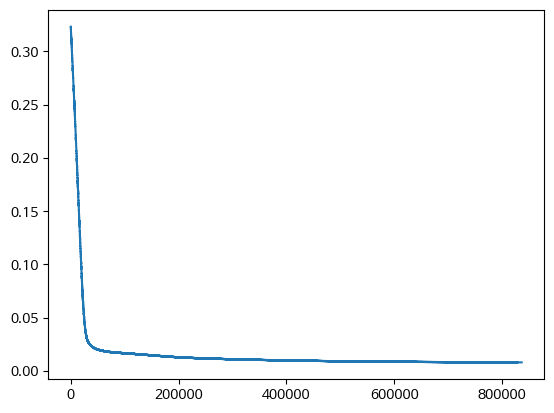

In [22]:
plt.plot(loss_list)

# Validation

In [23]:
torch.save(model.state_dict(), 'result/lstm_6window_selection_parameters.pth')
# model.load_state_dict(torch.load('result/lstm_selection_parameters.pth'))

In [24]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))

windoow_size = 6
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

In [25]:
df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

In [26]:
print(label_y.shape, predicted.shape)

(30475, 9) (30475, 9)


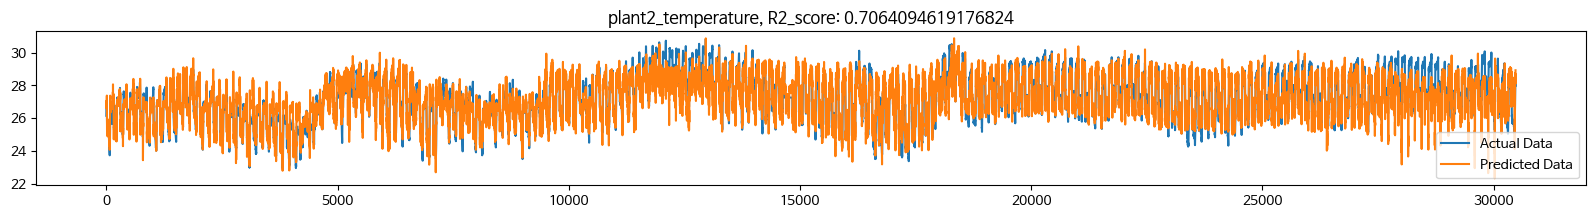

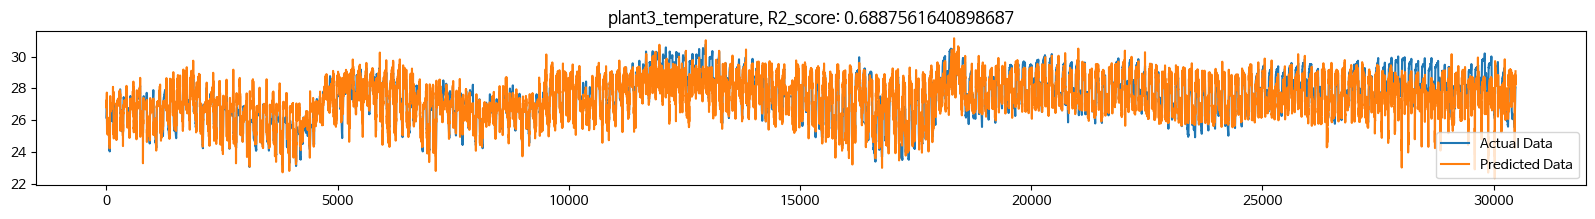

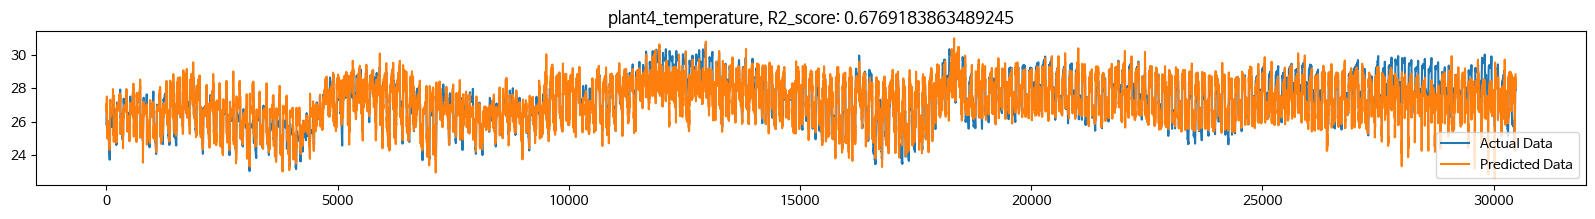

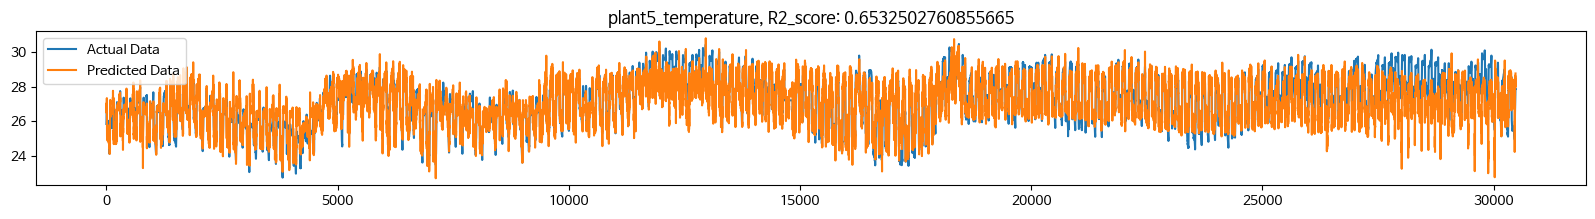

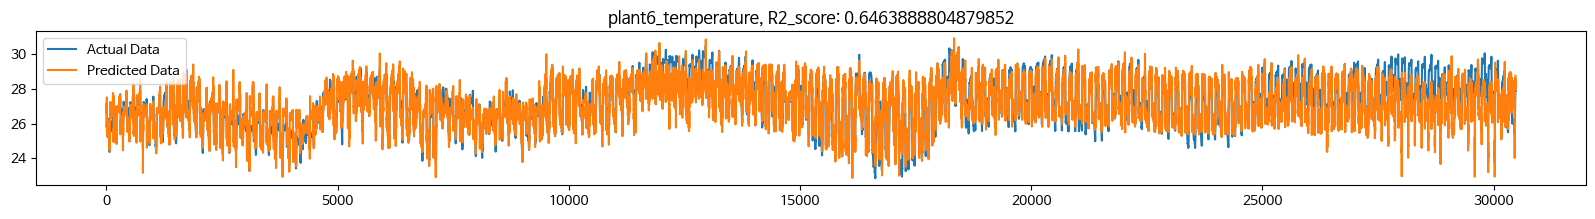

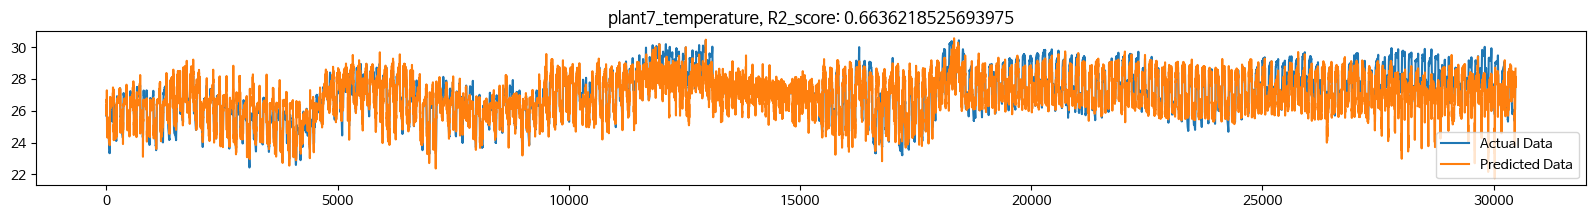

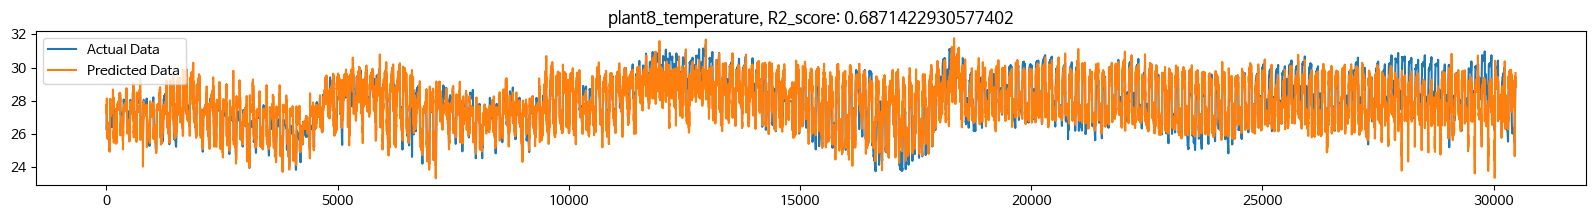

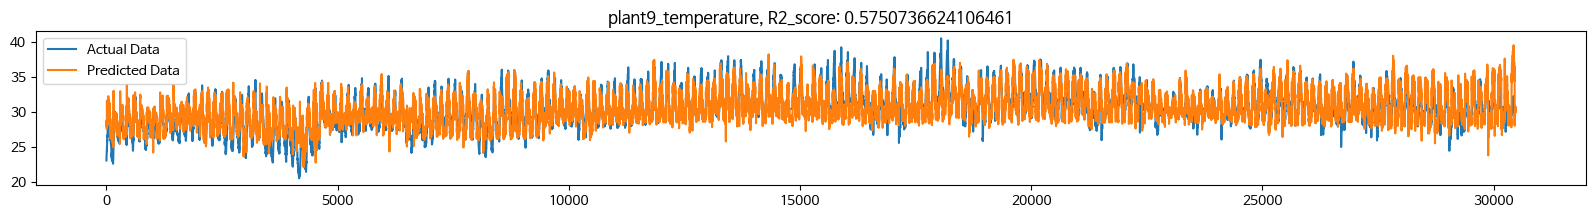

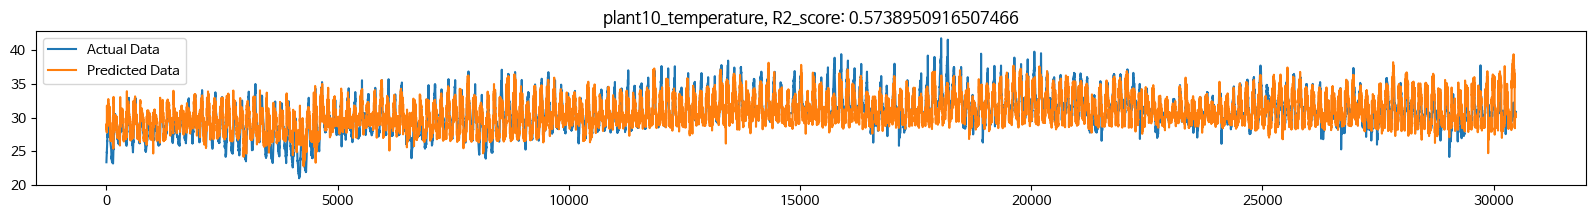

In [27]:
# plt.axvline(x=200, c='r', linestyle='--')

for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:,i], label='Actual Data')
  plt.plot(predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.legend()
  plt.show()

In [28]:
df_train.iloc[len_train:]

ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-06-19 15:20:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:30:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:40:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:50:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 16:00:00      45.0      35.0      45.0      45.0      40.0   
...                       ...       ...       ...       ...       ...   
2023-07-31 22:20:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:30:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:40:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:50:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 23:00:00       0.0       0.0       0.0       0.0       0.0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-06-19 15:20:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:30:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:40:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:50:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 16:00:00      45.0      45.0      45.0       45.0       45.0  ...   
...                       ...       ...       ...        ...        ...  ...   
2023-07-31 22:20:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:30:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:40:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:50:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 23:00:00       0.0       0.0       0.0        0.0        0.0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-06-19 15:20:00               25.96               25.94   
2023-06-19 15:30:00               25.95               25.98   
2023-06-19 15:40:00               25.95               25.98   
2023-06-19 15:50:00               25.92               26.03   
2023-06-19 16:00:00               25.92               25.98   
...                                 ...                 ...   
2023-07-31 22:20:00               27.87               27.87   
2023-07-31 22:30:00               27.87               27.90   
2023-07-31 22:40:00               27.87               27.87   
2023-07-31 22:50:00               27.90               27.86   
2023-07-31 23:00:00               27.87               27.89   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-06-19 15:20:00               26.25            37.69               26.52   
2023-06-19 15:30:00               26.22            37.80               26.49   
2023-06-19 15:40:00               26.21            37.92               26.51   
2023-06-19 15:50:00               26.27            37.96               26.58   
2023-06-19 16:00:00               26.27            37.98               26.52   
...                                 ...              ...                 ...   
2023-07-31 22:20:00               28.05            40.38               28.79   
2023-07-31 22:30:00               28.05            40.60               28.80   
2023-07-31 22:40:00               28.04            40.82               28.83   
2023-07-31 22:50:00               28.04            41.17               28.84   
2023-07-31 23:00:00               28.05            41.15               28.87   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-06-19 15:20:00      

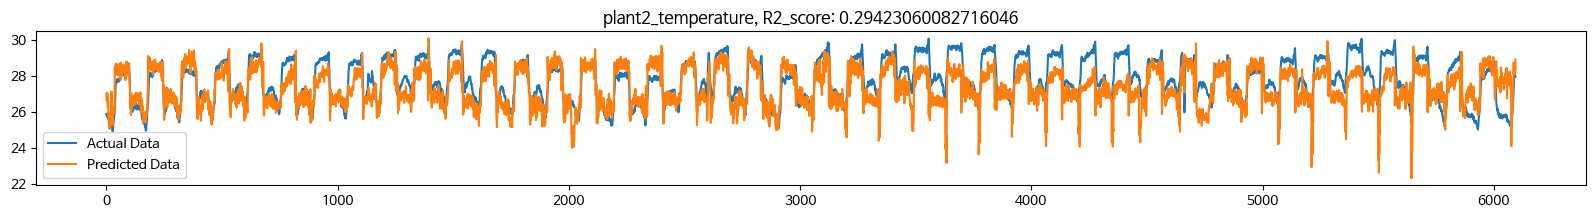

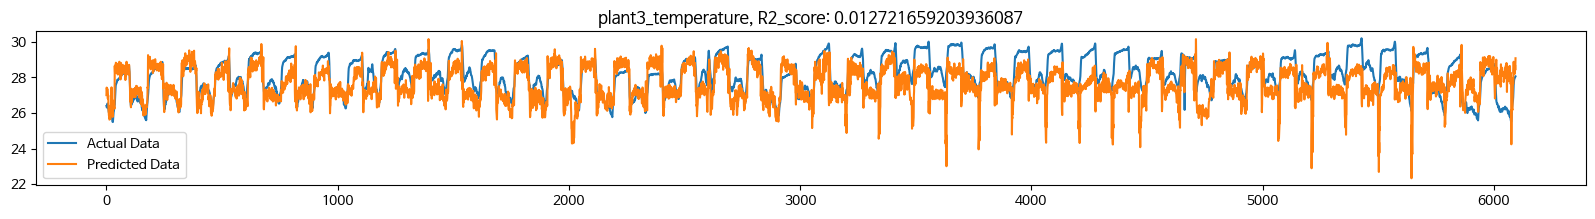

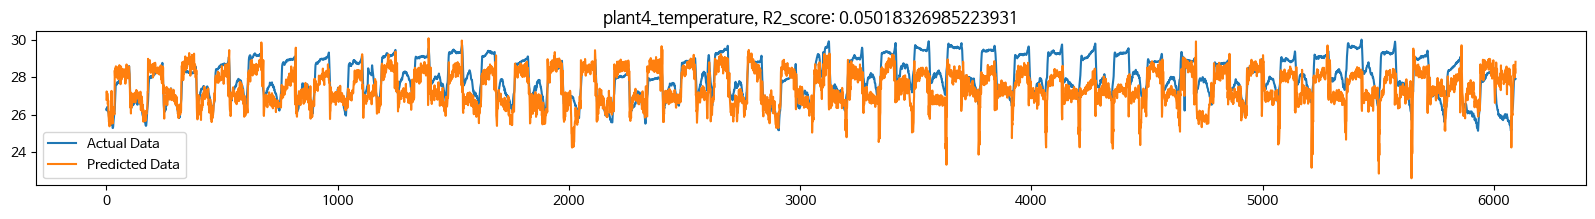

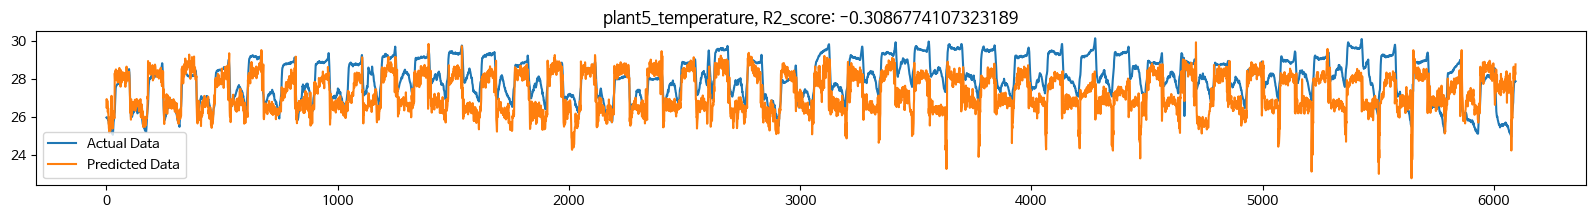

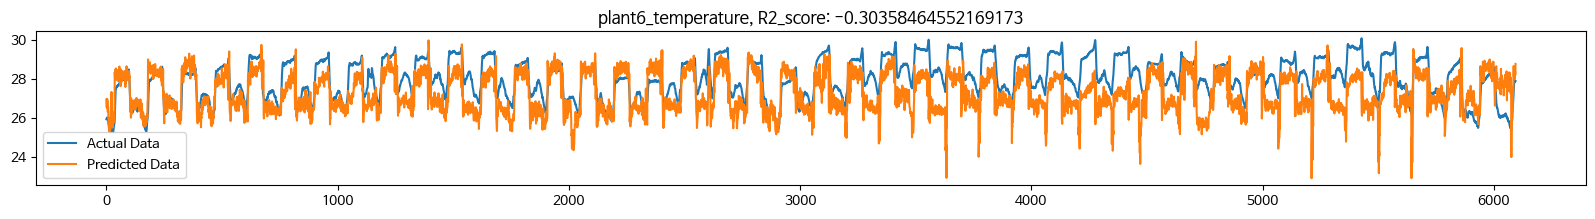

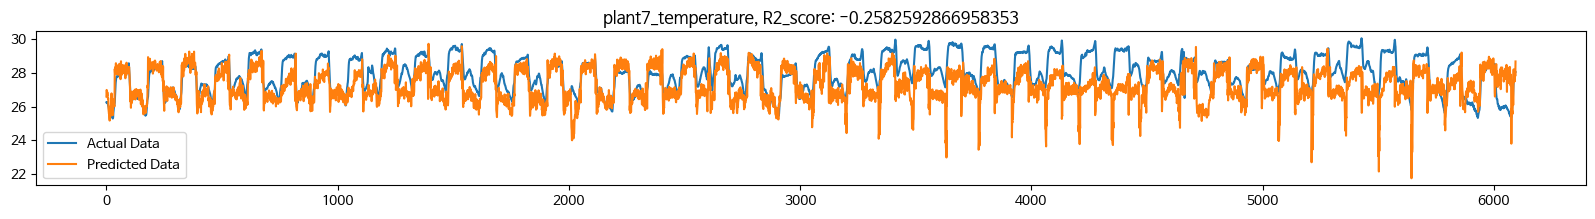

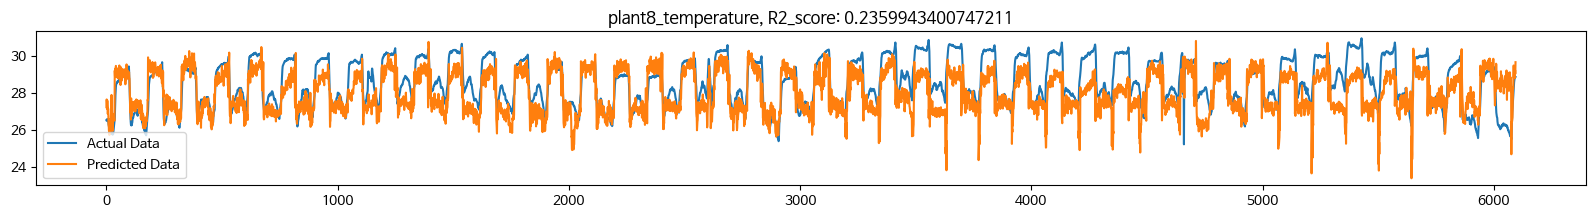

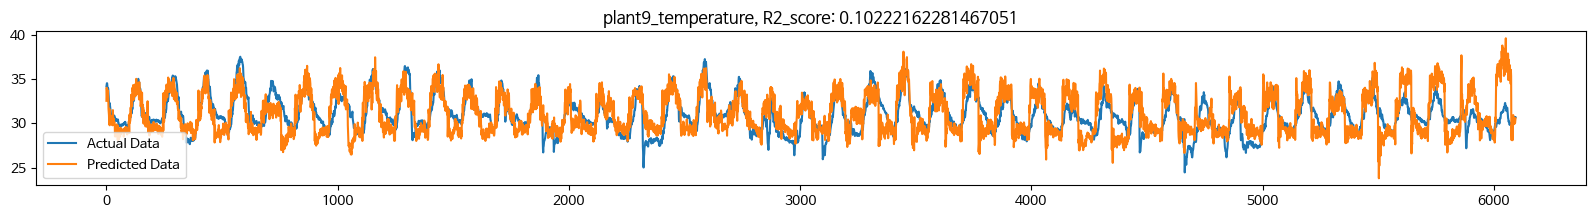

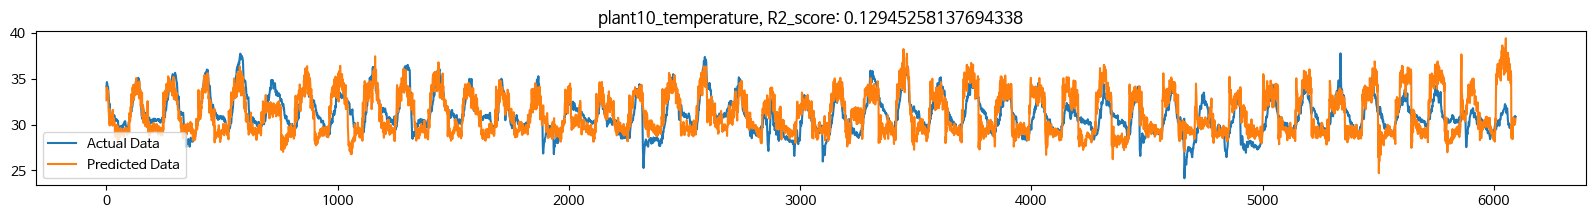

In [29]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(valid_y [:,i], label='Actual Data')
  plt.plot(gt_y[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(valid_y[:,i], gt_y[:,i])}')
  plt.legend()
  plt.show()

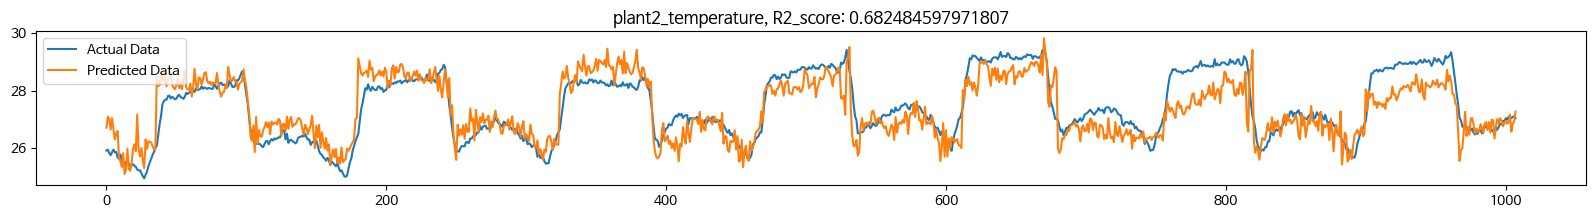

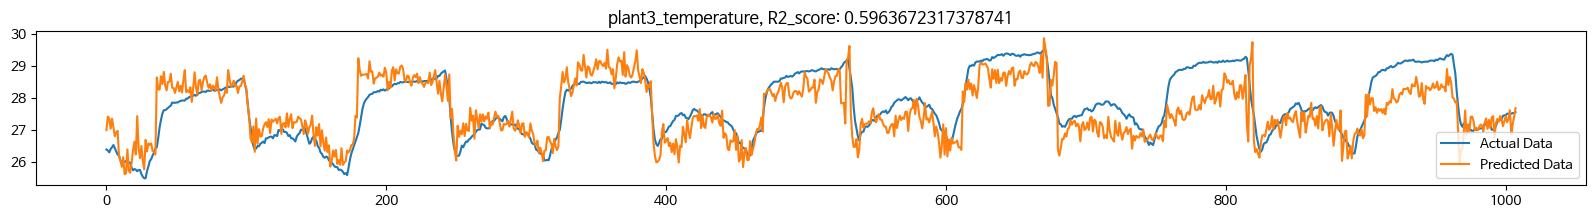

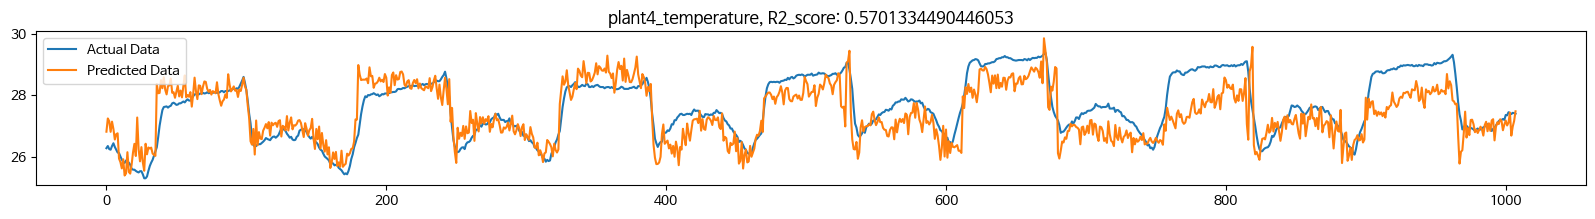

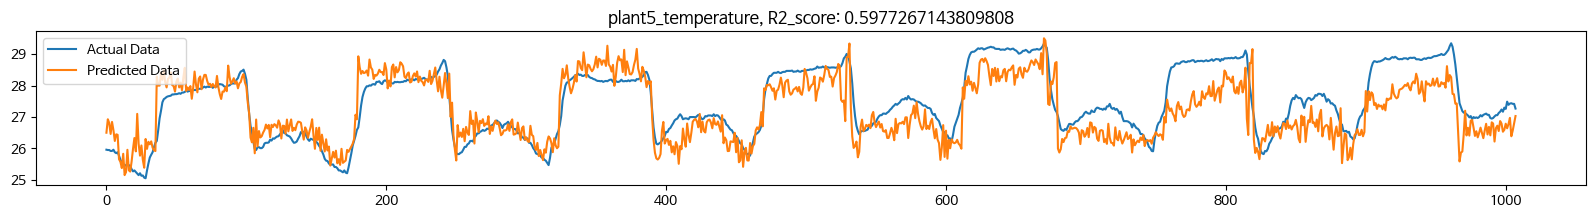

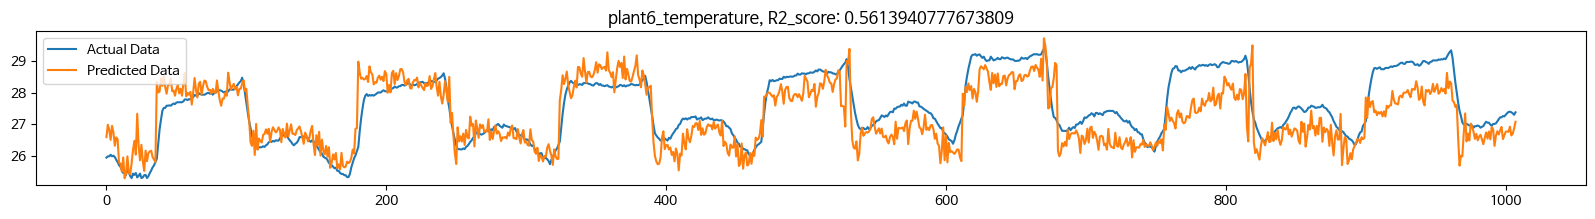

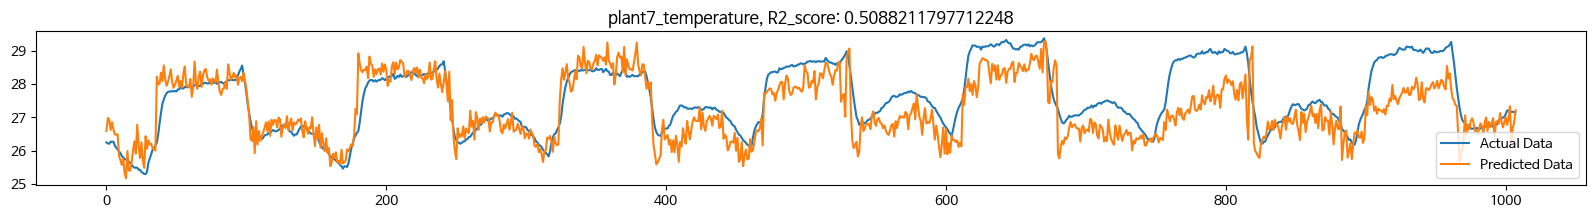

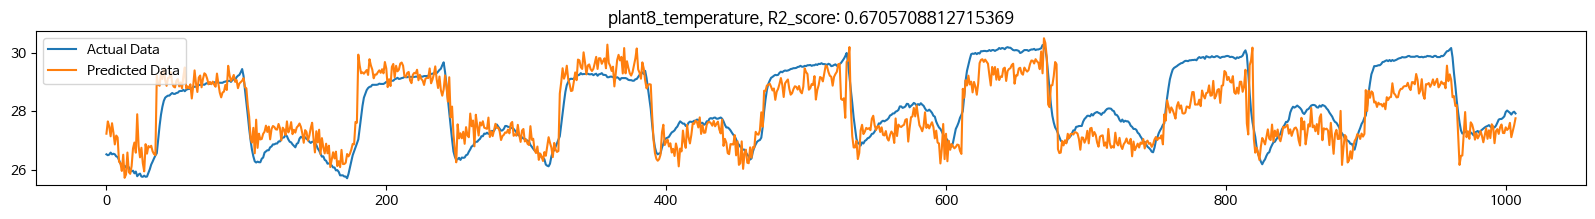

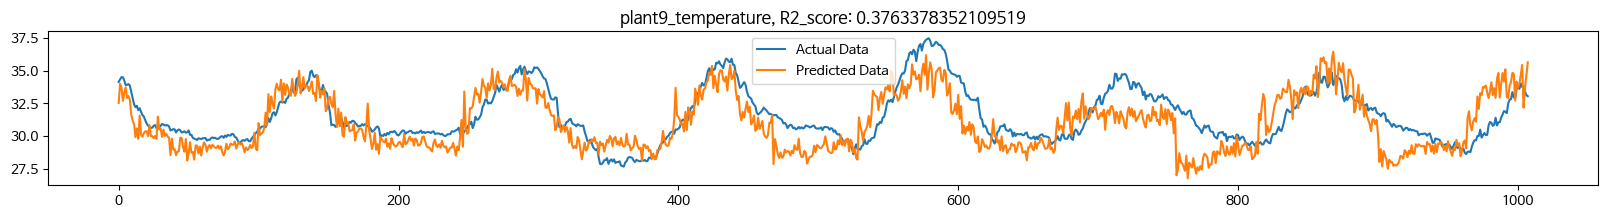

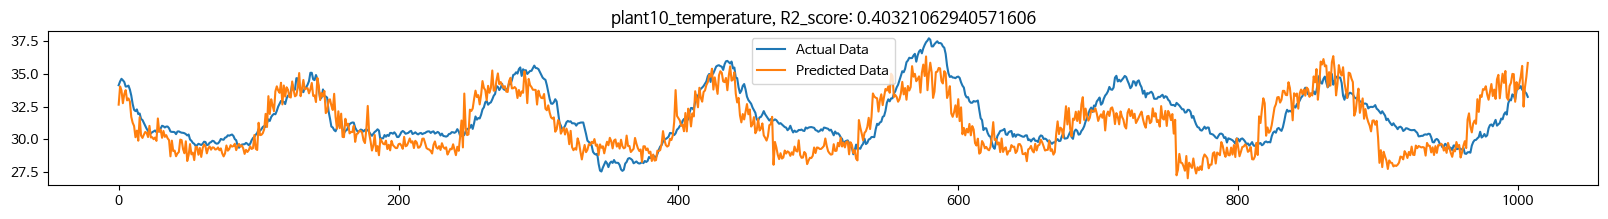

In [30]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(valid_y [:6*24*7,i], label='Actual Data')
  plt.plot(gt_y[:6*24*7,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(valid_y[:6*24*7:,i], gt_y[:6*24*7,i])}')
  plt.legend()
  plt.show()

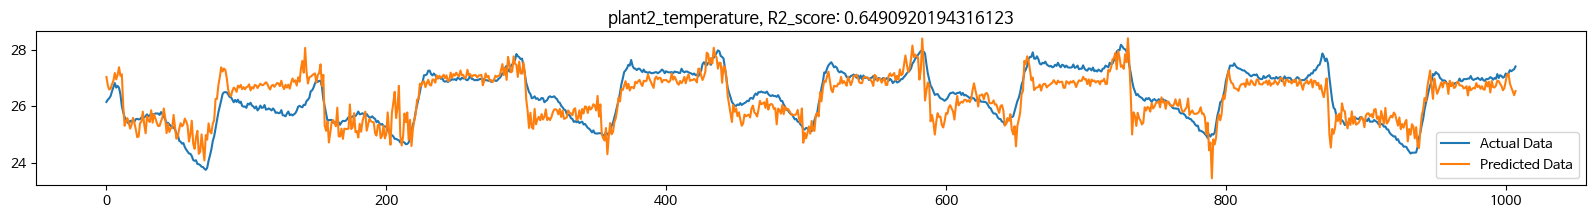

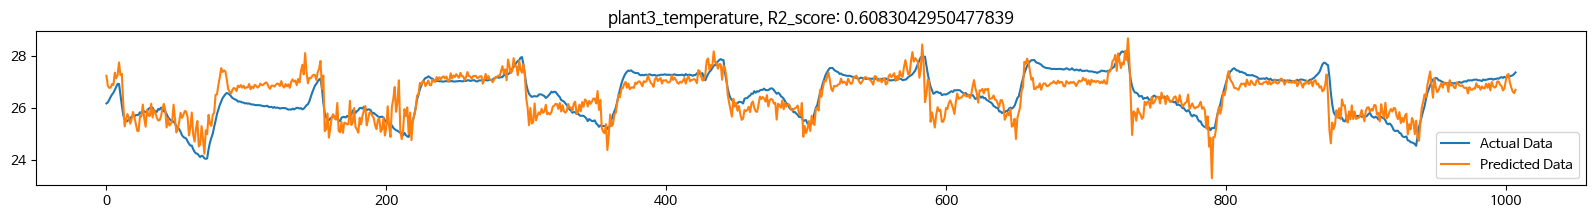

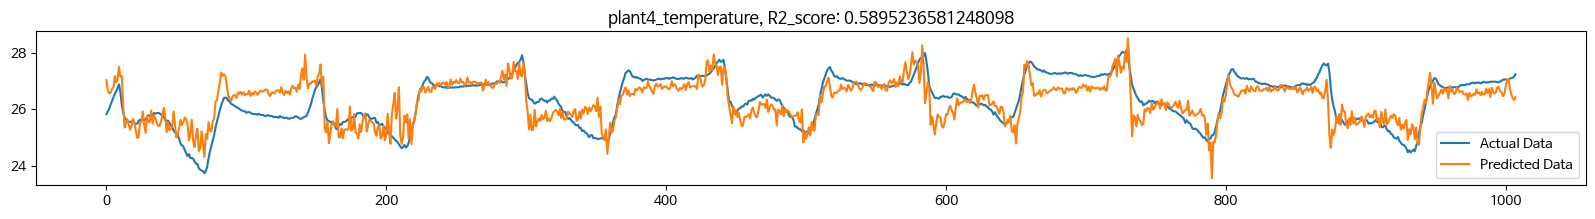

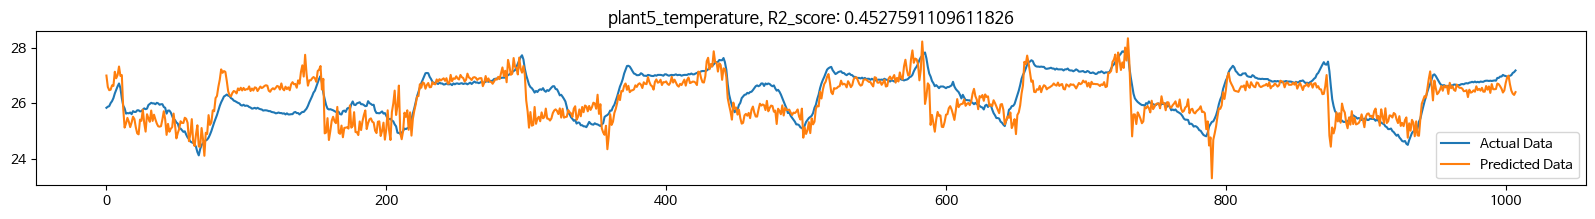

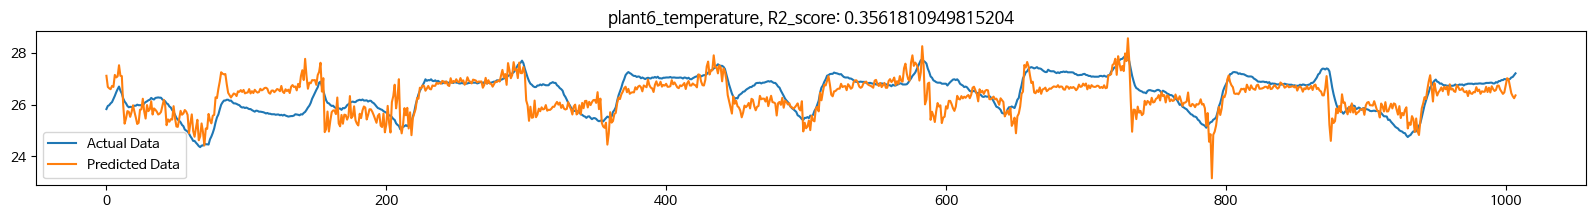

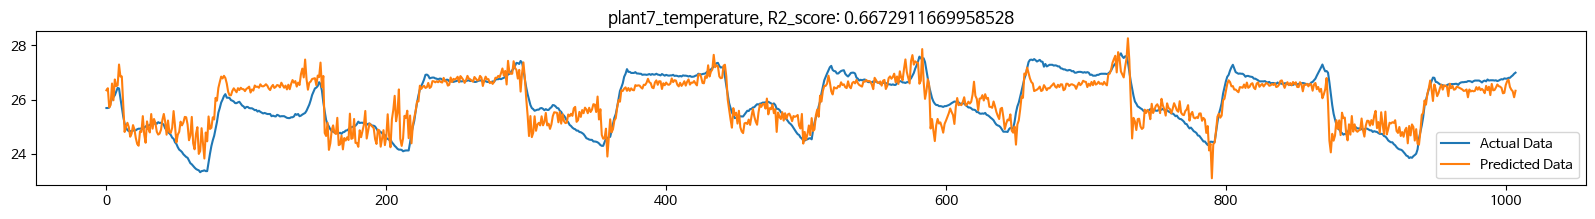

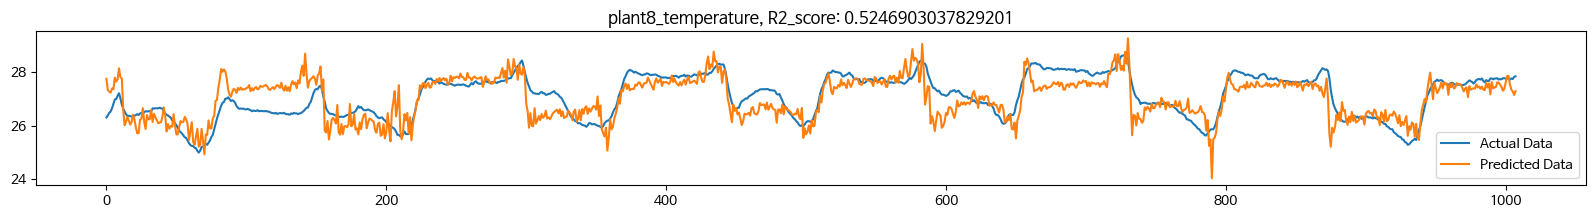

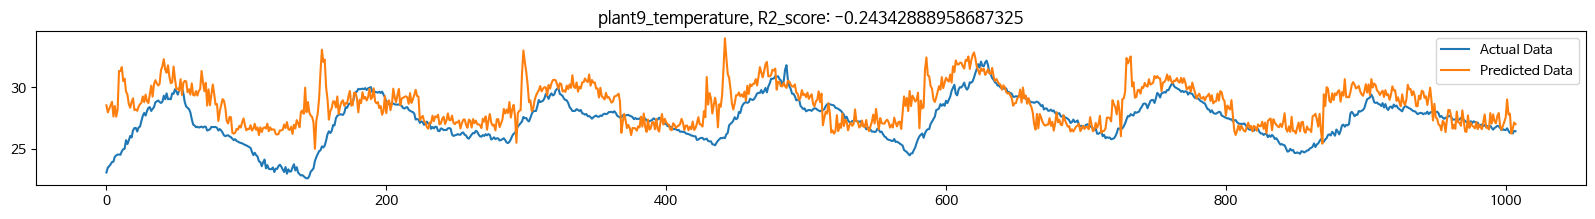

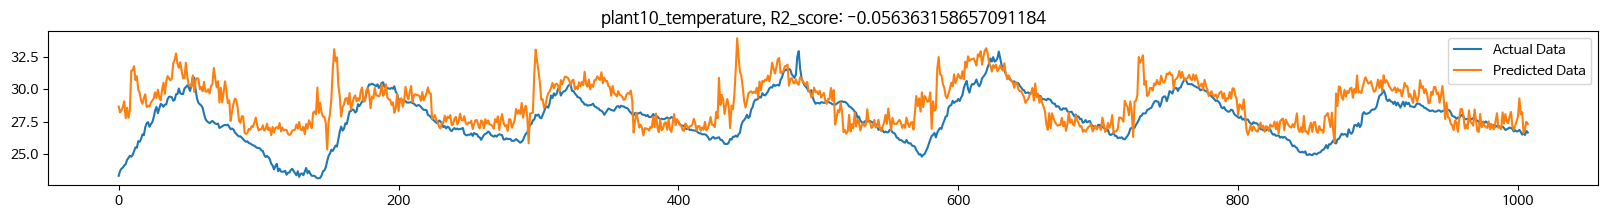

In [31]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:6*24*7,i], label='Actual Data')
  plt.plot(predicted[:6*24*7,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:6*24*7:,i], predicted[:6*24*7,i])}')
  plt.legend()
  plt.show()

# test

In [32]:
df_test

ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-08-01 00:00:00         0         0         0         0         0   
2023-08-01 00:10:00         0         0         0         0         0   
2023-08-01 00:20:00         0         0         0         0         0   
2023-08-01 00:30:00         0         0         0         0         0   
2023-08-01 00:40:00         0         0         0         0         0   
...                       ...       ...       ...       ...       ...   
2023-09-30 23:10:00         0         0         0         0         0   
2023-09-30 23:20:00         0         0         0         0         0   
2023-09-30 23:30:00         0         0         0         0         0   
2023-09-30 23:40:00         0         0         0         0         0   
2023-09-30 23:50:00         0         0         0         0         0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-08-01 00:00:00         0         0         0          0          0  ...   
2023-08-01 00:10:00         0         0         0          0          0  ...   
2023-08-01 00:20:00         0         0         0          0          0  ...   
2023-08-01 00:30:00         0         0         0          0          0  ...   
2023-08-01 00:40:00         0         0         0          0          0  ...   
...                       ...       ...       ...        ...        ...  ...   
2023-09-30 23:10:00         0         0         0          0          0  ...   
2023-09-30 23:20:00         0         0         0          0          0  ...   
2023-09-30 23:30:00         0         0         0          0          0  ...   
2023-09-30 23:40:00         0         0         0          0          0  ...   
2023-09-30 23:50:00         0         0         0          0          0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-08-01 00:00:00               27.85               27.85   
2023-08-01 00:10:00               27.87               27.86   
2023-08-01 00:20:00               27.87               27.88   
2023-08-01 00:30:00               27.87               27.85   
2023-08-01 00:40:00               27.86               27.85   
...                                 ...                 ...   
2023-09-30 23:10:00               28.04               27.74   
2023-09-30 23:20:00               28.04               27.74   
2023-09-30 23:30:00               28.03               27.76   
2023-09-30 23:40:00               28.01               27.76   
2023-09-30 23:50:00               28.01               27.74   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-08-01 00:00:00               27.98            41.65               28.85   
2023-08-01 00:10:00               27.98            41.77               28.85   
2023-08-01 00:20:00               27.98            41.85               28.86   
2023-08-01 00:30:00               27.98            41.96               28.89   
2023-08-01 00:40:00               27.98            41.94               28.89   
...                                 ...              ...                 ...   
2023-09-30 23:10:00               27.81            46.15               28.87   
2023-09-30 23:20:00               27.81            46.15               28.85   
2023-09-30 23:30:00               27.81            46.18               28.83   
2023-09-30 23:40:00               27.80            46.22               28.81   
2023-09-30 23:50:00               27.80            46.27               28.83   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-08-01 00:00:00      

In [33]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

window_size = 6

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

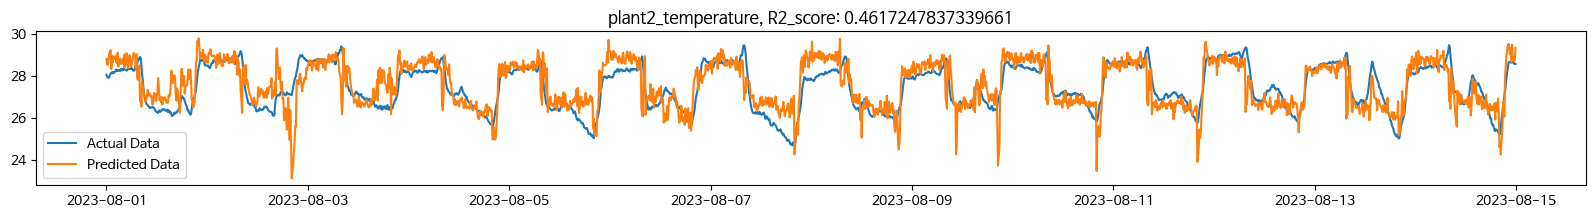

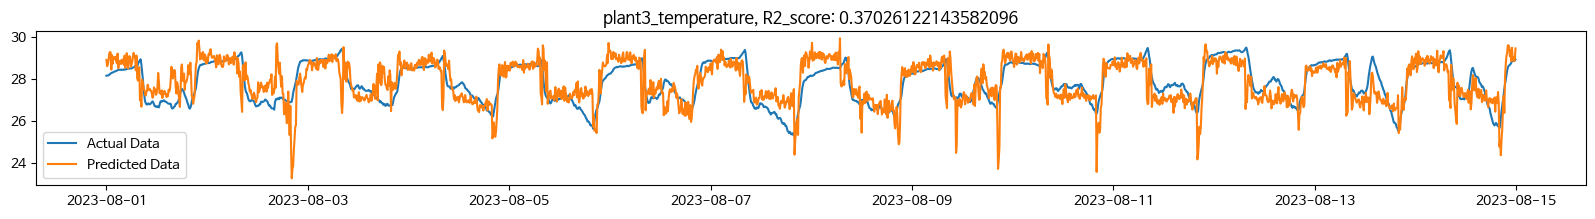

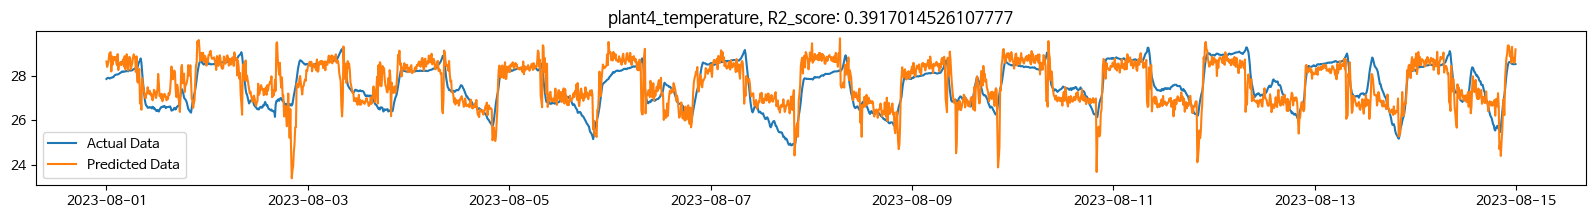

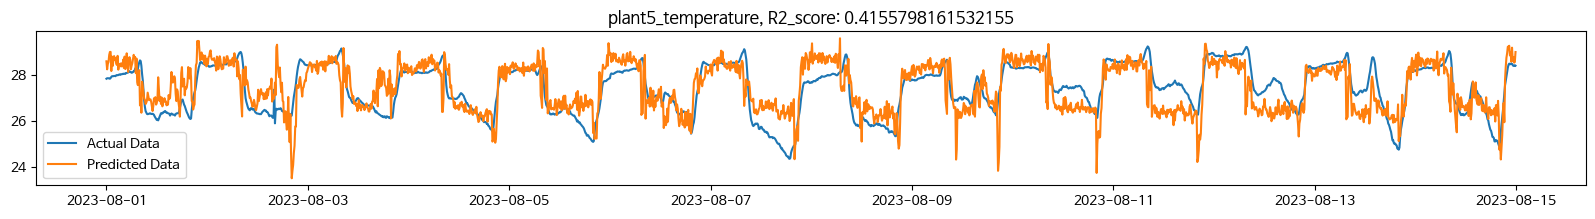

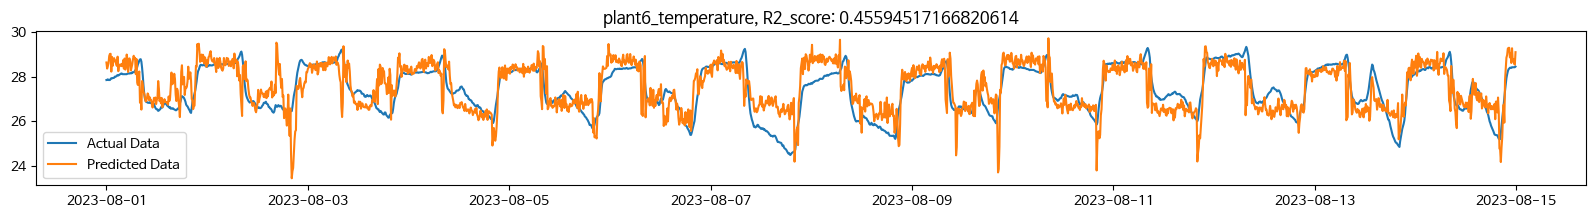

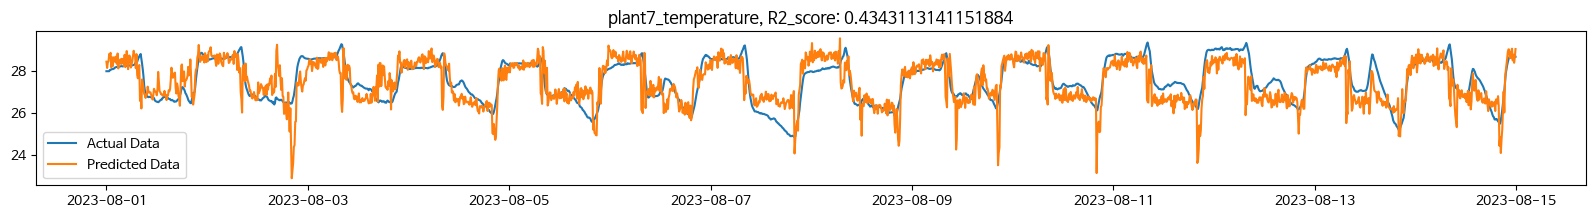

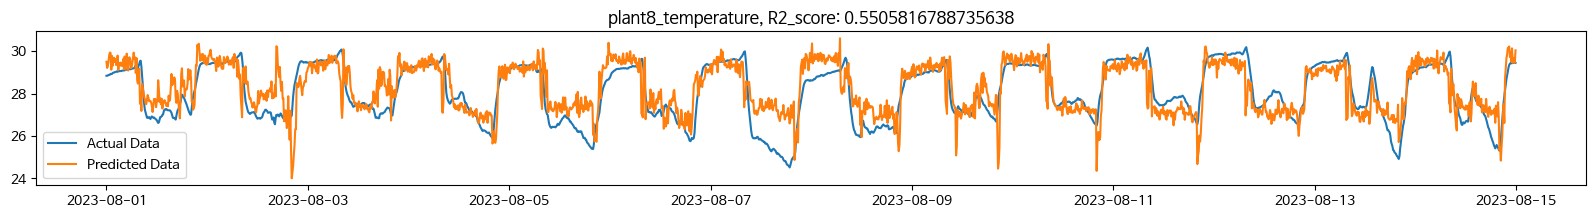

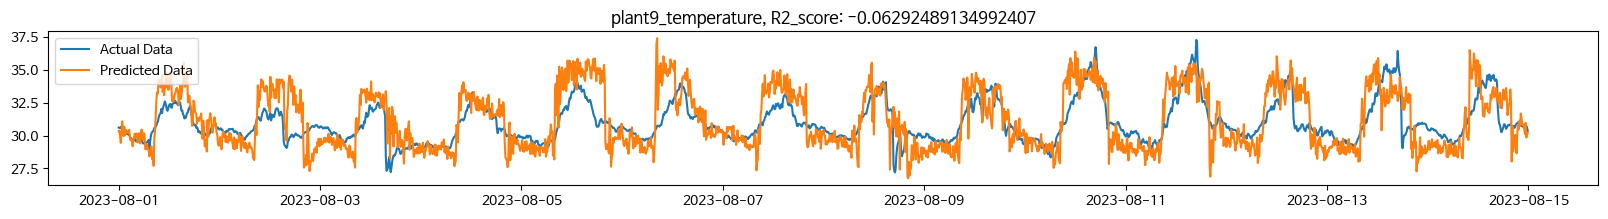

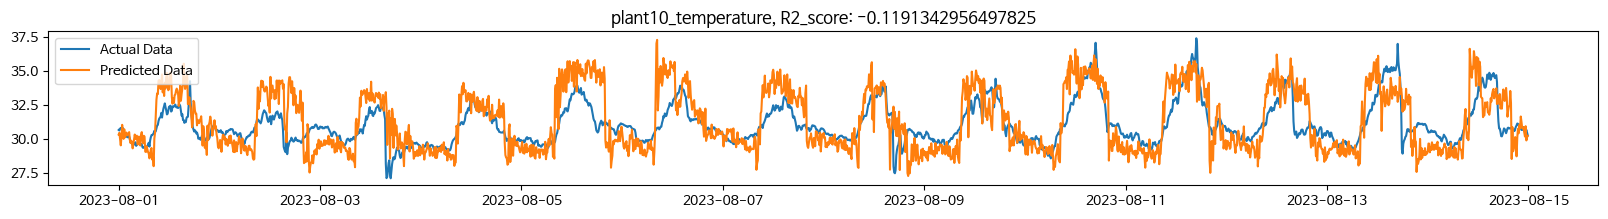

In [34]:
# plt.axvline(x=200, c='r', linestyle='--')
week2 = 2*7*24*6
start_date = "2023-08-01 00:00:00"
end_date = "2023-08-14 23:50:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[:week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')
# week2 = 2*7*24*6
start_date = "2023-08-01 00:00:00"
end_date = "2023-09-30 23:50:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(date_range, label_y[:,i], label='Actual Data')
  plt.plot(date_range, predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.legend()
  plt.show()

In [36]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,9)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(9):
    result[f'plant{i+1}_temperature'] = label_y[:,i]

In [37]:
result.to_csv('result/temp_6window_result.csv')

In [ ]:
 q